In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

from scipy import stats

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
ops_directory = 'C:\\Users\insan\\Desktop\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

#opsin
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']
all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#Ephy
ephys_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

# Animal Behavior

In [2]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

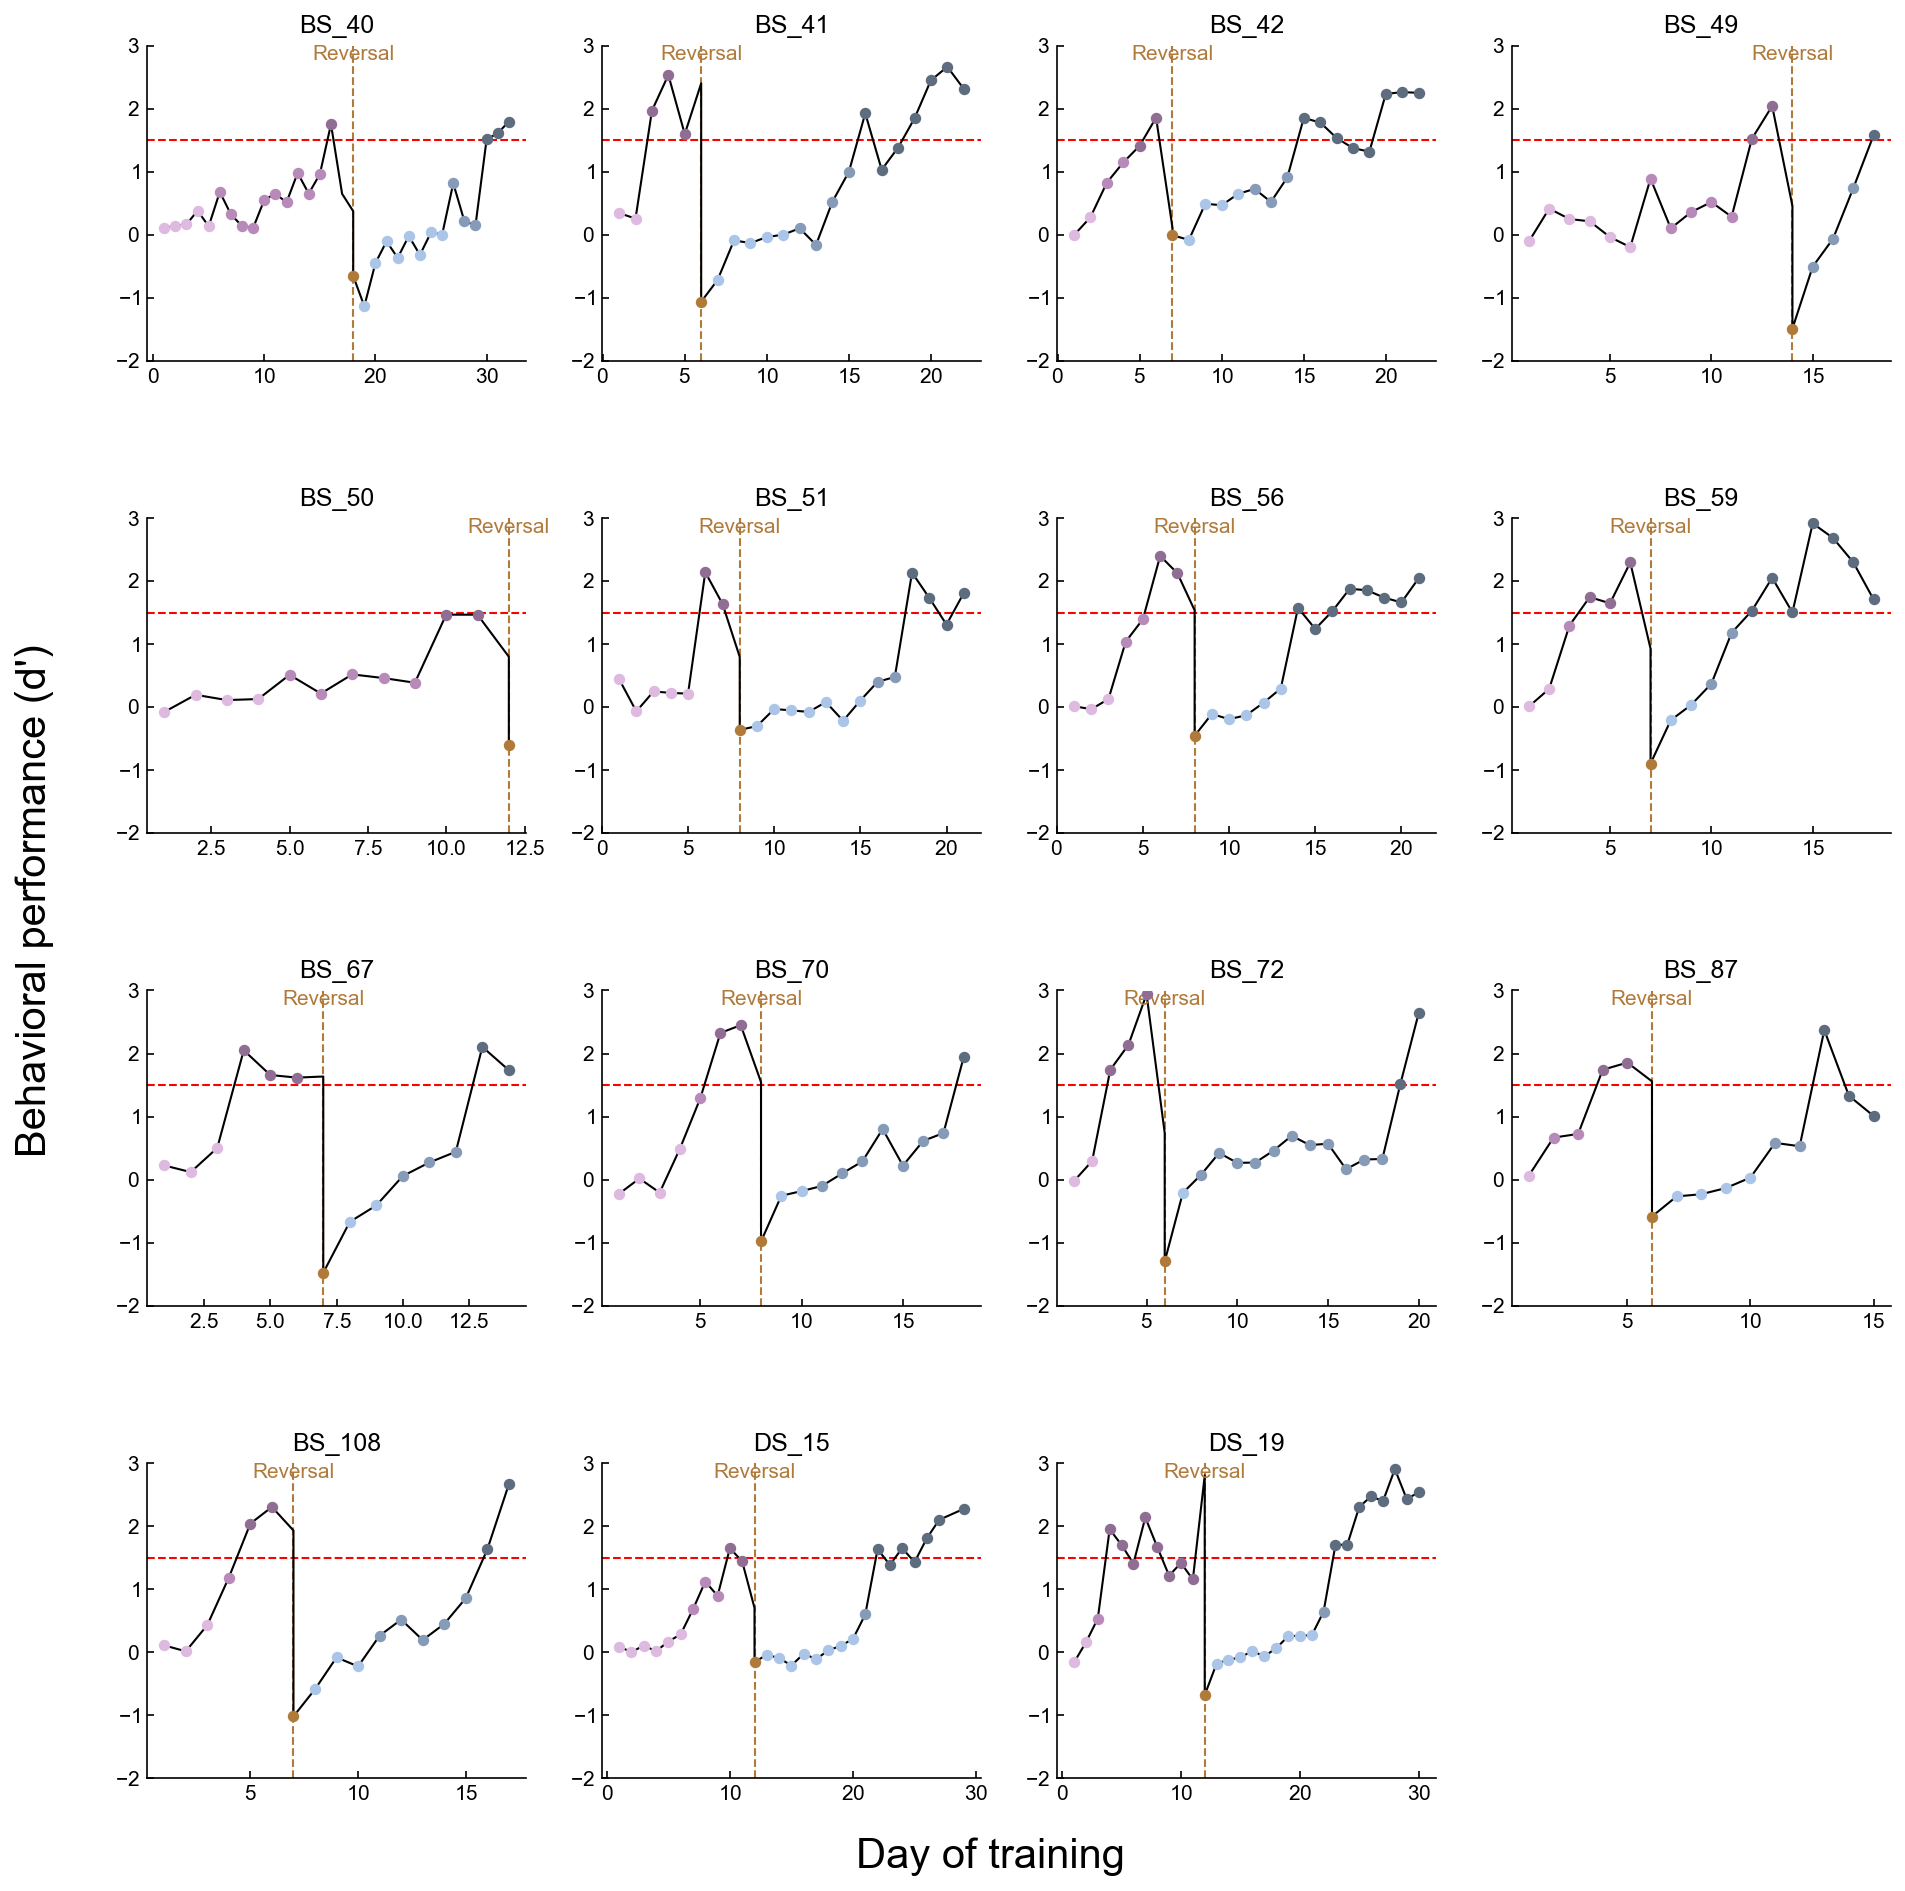

In [3]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(ephys_animals,animalBehaviors,plot=True)

# Get data

In [4]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in ephys_animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass
        


        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|██████████| 722/722 [00:12<00:00, 56.67it/s] 

AC       : 1832
M2       : 1628


## Assign each good cluster its learning phase

In [5]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1628/1628 [00:28<00:00, 57.10it/s] 

errors for: []


In [6]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1832/1832 [00:37<00:00, 49.05it/s] 

errors for: []


In [7]:
EILACphases

array(['pre expert', 'pre expert', 'pre expert', ..., 'post early',
       'post early', 'post early'], dtype='<U18')

In [8]:
EILM2phases

array(['pre expert', 'pre expert', 'pre expert', ..., 'post late',
       'post late', 'post late'], dtype='<U18')

In [9]:
animalBehaviors['BS_50'].reversal

12

In [10]:
animalBehaviors['BS_50'].sessions[12]

namespace(animal='BS_50',
          session=12,
          files=array(['BS_50_12v1.txt', 'BS_50_12v1_reversal.txt',
                       'BS_50_12v3_reversal.txt', 'BS_50_12v4_reversal.txt'], dtype='<U23'),
          blocknumbers=array([1, 1, 3, 4]),
          type='switch',
          trials_per_session=array([200.,  29.,  29.,  82.]),
          outcomes=0     1
                   1     1
                   2     1
                   3     1
                   4     1
                        ..
                   77    2
                   78    2
                   79    4
                   80    2
                   81    2
                   Name: outcome, Length: 340, dtype: int64,
          response_time=0     0.31441
                        1     0.31244
                        2     0.31482
                        3     0.31450
                        4     0.31454
                               ...   
                        77    2.50030
                        78    2.5003

In [11]:
preearly_animals_M2 = []
prelate_animals_M2  = []
preexpert_animals_M2  = []
postearly_animals_M2  = []
postlate_animals_M2  = []
postexpert_animals_M2  = []

FRmod_preearly_M2 = []
FRmod_prelate_M2 = []
FRmod_preexpert_M2 = []
FRmod_postearly_M2 = []
FRmod_postlate_M2 = []
FRmod_postexpert_M2 = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILM2phases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if EILM2phases[idx] == 'pre early':
        FRmod_preearly_M2.append(FRmod)
        preearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'pre late':
        FRmod_prelate_M2.append(FRmod)
        prelate_animals_M2.append(sessionfile.meta.animal)  
        
    elif EILM2phases[idx] == 'pre expert':
        FRmod_preexpert_M2.append(FRmod)
        preexpert_animals_M2.append(sessionfile.meta.animal)     
        
    elif EILM2phases[idx] == 'post early':
        FRmod_postearly_M2.append(FRmod)
        postearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'post late':
        FRmod_postlate_M2.append(FRmod)
        postlate_animals_M2.append(sessionfile.meta.animal)    
        
    elif EILM2phases[idx] == 'post expert':
        FRmod_postexpert_M2.append(FRmod)
        postexpert_animals_M2.append(sessionfile.meta.animal)

FRmod_preearly_M2 = np.array(FRmod_preearly_M2)
FRmod_prelate_M2 = np.array(FRmod_prelate_M2)
FRmod_preexpert_M2 = np.array(FRmod_preexpert_M2)
FRmod_postearly_M2 = np.array(FRmod_postearly_M2)
FRmod_postlate_M2 = np.array(FRmod_postlate_M2)
FRmod_postexpert_M2 = np.array(FRmod_postexpert_M2)

1628it [00:28, 56.96it/s] 


In [12]:
len(FRmod_preearly_M2)

159

In [13]:
preearly_animals_AC = []
prelate_animals_AC  = []
preexpert_animals_AC  = []
postearly_animals_AC  = []
postlate_animals_AC  = []
postexpert_animals_AC  = []

FRmod_preearly_AC = []
FRmod_prelate_AC = []
FRmod_preexpert_AC = []
FRmod_postearly_AC = []
FRmod_postlate_AC = []
FRmod_postexpert_AC = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILACphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if EILACphases[idx] == 'pre early':
        FRmod_preearly_AC.append(FRmod)
        preearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'pre late':
        FRmod_prelate_AC.append(FRmod)
        prelate_animals_AC.append(sessionfile.meta.animal)  
        
    elif EILACphases[idx] == 'pre expert':
        FRmod_preexpert_AC.append(FRmod)
        preexpert_animals_AC.append(sessionfile.meta.animal)     
        
    elif EILACphases[idx] == 'post early':
        FRmod_postearly_AC.append(FRmod)
        postearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'post late':
        FRmod_postlate_AC.append(FRmod)
        postlate_animals_AC.append(sessionfile.meta.animal)    
        
    elif EILACphases[idx] == 'post expert':
        FRmod_postexpert_AC.append(FRmod)
        postexpert_animals_AC.append(sessionfile.meta.animal)

FRmod_preearly_AC = np.array(FRmod_preearly_AC)
FRmod_prelate_AC = np.array(FRmod_prelate_AC)
FRmod_preexpert_AC = np.array(FRmod_preexpert_AC)
FRmod_postearly_AC = np.array(FRmod_postearly_AC)
FRmod_postlate_AC = np.array(FRmod_postlate_AC)
FRmod_postexpert_AC = np.array(FRmod_postexpert_AC)

1338it [00:27, 118.43it/s]

1
4
6
8
17
19
22
31
32
42
47
48
60
9
11
12
20
25
34
41
42
60
65
67
69


1352it [00:27, 118.38it/s]

70
79
80
84
86
93
98
99
102
105
111
112
113


1832it [00:37, 49.23it/s] 


In [14]:
preearly_animals_M2 = np.unique(preearly_animals_M2)
prelate_animals_M2 = np.unique(prelate_animals_M2)
preexpert_animals_M2 = np.unique(preexpert_animals_M2)
postearly_animals_M2 = np.unique(postearly_animals_M2)
postlate_animals_M2 = np.unique(postlate_animals_M2)
postexpert_animals_M2 = np.unique(postexpert_animals_M2)

preearly_animals_AC = np.unique(preearly_animals_AC)
prelate_animals_AC = np.unique(prelate_animals_AC)
preexpert_animals_AC = np.unique(preexpert_animals_AC)
postearly_animals_AC = np.unique(postearly_animals_AC)
postlate_animals_AC = np.unique(postlate_animals_AC)
postexpert_animals_AC = np.unique(postexpert_animals_AC)

print('M2 Animals')
print(preearly_animals_M2)
print(prelate_animals_M2)
print(preexpert_animals_M2)
print(postearly_animals_M2)
print(postlate_animals_M2)
print(postexpert_animals_M2)
print('AC Animals')
print(preearly_animals_AC)
print(prelate_animals_AC)
print(preexpert_animals_AC)
print(postearly_animals_AC)
print(postlate_animals_AC)
print(postexpert_animals_AC)

###MAY NEED TO MATCH AC AND M2 ANIMALS!!!

M2 Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_50' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_41' 'BS_42' 'BS_51' 'BS_56' 'BS_59' 'BS_67' 'BS_87']
AC Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_40' 'BS_49' 'BS_72' 'BS_87' 'DS_15' 'DS_19']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_51' 'BS_56' 'BS_67' 'BS_70' 'BS_87'
 'DS_15' 'DS_19']


In [15]:
print(len(FRmod_preearly_AC))
print(len(FRmod_prelate_AC))
print(len(FRmod_preexpert_AC))
print(len(FRmod_postearly_AC))
print(len(FRmod_postlate_AC))
print(len(FRmod_postexpert_AC))

148
188
117
349
299
285


In [16]:
print(len(FRmod_preearly_M2))
print(len(FRmod_prelate_M2))
print(len(FRmod_preexpert_M2))
print(len(FRmod_postearly_M2))
print(len(FRmod_postlate_M2))
print(len(FRmod_postexpert_M2))

159
240
199
349
204
218


In [17]:
ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded=None)

{'all_trials': namespace(trials=array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
                          13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
                          26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
                          39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
                          52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
                          65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
                          78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
                          91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
                         104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
                         117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
                         130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 1

In [18]:
ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded=None)['target']

namespace(trials=array([  0,   1,   2,   3,   4,   7,   8,  11,  12,  15,  17,  19,  23,
                         25,  26,  28,  29,  30,  32,  35,  38,  39,  43,  44,  45,  48,
                         49,  50,  52,  53,  55,  59,  60,  61,  64,  65,  69,  70,  71,
                         72,  74,  77,  82,  83,  85,  86,  87,  90,  91,  95,  96,  98,
                        103, 105, 106, 107, 108, 111, 113, 114, 117, 119, 120, 123, 125,
                        127, 128, 130, 131, 135, 136, 139, 141, 142, 143, 144, 145, 151,
                        153, 154, 157, 159, 162, 163, 166, 168, 169, 170, 173, 175, 176,
                        178, 180, 181, 182, 186, 188, 190, 193, 194, 197, 199, 204, 205,
                        206, 208, 209, 210, 212, 213, 214, 217, 220, 222, 224, 225, 229,
                        232, 234, 235, 236, 237, 241, 242, 243, 247, 248, 252, 253, 254,
                        255, 259, 261, 262, 263, 266, 268, 271, 272, 275, 277, 278, 284,
                     

In [19]:
ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded=None)['target'].trials

array([  0,   1,   2,   3,   4,   7,   8,  11,  12,  15,  17,  19,  23,
        25,  26,  28,  29,  30,  32,  35,  38,  39,  43,  44,  45,  48,
        49,  50,  52,  53,  55,  59,  60,  61,  64,  65,  69,  70,  71,
        72,  74,  77,  82,  83,  85,  86,  87,  90,  91,  95,  96,  98,
       103, 105, 106, 107, 108, 111, 113, 114, 117, 119, 120, 123, 125,
       127, 128, 130, 131, 135, 136, 139, 141, 142, 143, 144, 145, 151,
       153, 154, 157, 159, 162, 163, 166, 168, 169, 170, 173, 175, 176,
       178, 180, 181, 182, 186, 188, 190, 193, 194, 197, 199, 204, 205,
       206, 208, 209, 210, 212, 213, 214, 217, 220, 222, 224, 225, 229,
       232, 234, 235, 236, 237, 241, 242, 243, 247, 248, 252, 253, 254,
       255, 259, 261, 262, 263, 266, 268, 271, 272, 275, 277, 278, 284,
       285, 286, 287, 288, 293, 294, 295, 298, 299, 300, 301, 305, 307,
       308, 311, 312, 315, 316, 318, 323, 324, 326, 327, 328, 331, 332,
       334, 335, 336, 341, 342, 344, 348, 349, 351, 352, 353, 35

# Analysis

# Pairwise correlation between a pair of neurons 

In [20]:
#Calculate pairwise correlation between pairs in one session in one region
#Steps:
#Define sessionfile, get good clusters from this sessionfile
#Get all pairs from this session
#For each pair, get trials to use, calculate spike count residual for each cell in this pair, then calculate the pearson correlation
#Go to next pair

In [21]:
#Get one session's pairs
def getSessionPairs(sessionfile):
    #get good clusters from this sessionfile
    sessionfile_clust = []
    for clust in sessionfile.clusters.good:
        sessionfile_clust.append(clust)

    cluster_pairs = [(sessionfile_clust[i],sessionfile_clust[j]) for i in range(len(sessionfile_clust)) for j in range(i+1,len(sessionfile_clust))]
    
    return cluster_pairs
    

In [22]:
#Trials to use for each pair of cell should be the same, use the intersection
def getTrialsforPair(sessionfile,clustA,clustB,trial_condition):
    trials_to_use_A = ilep.getAllConditions(sessionfile,clustA,trialsPerDayLoaded=None)[trial_condition]
    trials_to_use_A = trials_to_use_A.trials
    #print(len(trials_to_use_A))
    
    trials_to_use_B = ilep.getAllConditions(sessionfile,clustB,trialsPerDayLoaded=None)[trial_condition]
    trials_to_use_B = trials_to_use_B.trials
    #print(len(trials_to_use_B))
    
    trials_to_use = np.intersect1d(trials_to_use_A,trials_to_use_B)
    #print(len(trials_to_use))
          
    return trials_to_use

In [23]:
#Count a cell's spike counts residual across all trials to use
def countClustSpikes_alltrials(sessionfile,clust,window_length,trials_to_use):

    start_times = sessionfile.trials.starts
    start_times = [start_times[trial_id] for trial_id in trials_to_use]
    #print(len(start_times))
    
    spike_time_trials = []
    for start_time in start_times:
        end_time = start_time + window_length*30000 
        spike_time = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start_time,endtime=end_time)
        spike_time_trials.append(spike_time)
    #print(len(spike_time_trials))
          
    spike_count_trials = []
    for spiketime in spike_time_trials:
        spike_count = len(spiketime)
        spike_count_trials.append(spike_count)
    #print(len(spike_count_trials))
    
    spike_count_trials = np.array(spike_count_trials)
    spike_count_mean = np.mean(spike_count_trials)
    res_spike_count_trials = spike_count_trials - spike_count_mean
    
    return spike_count_trials, spike_count_mean, res_spike_count_trials

In [24]:
#Using a 200ms window from the start of the trial to count for the spikes
window_length = 0.2 #200ms


In [25]:
#Only calculate a pair-wise corr for a pair within one session and one learning phease

In [26]:
AC_sessions = np.unique(EnumACSession)
M2_sessions = np.unique(EnumM2Session)

In [27]:
ACphases = np.full_like(AC_sessions,np.nan)
error_animals = []

AC_switch = []
AC_preearly = []
AC_prelate = []
AC_preexpert = []
AC_postearly = []
AC_postlate = []
AC_postexpert = []

for idx,session in enumerate(tqdm(AC_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            ACphases[idx] = 'switch'
            AC_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            ACphases[idx] = 'pre early'
            AC_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            ACphases[idx] = 'pre late'
            AC_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            ACphases[idx] = 'pre expert'
            AC_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            ACphases[idx] = 'post early'
            AC_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            ACphases[idx] = 'post late'
            AC_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            ACphases[idx] = 'post expert'
            AC_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

print(len(ACphases))
print(len(AC_preearly))
print(len(AC_prelate))
print(len(AC_preexpert))
print(len(AC_postearly))
print(len(AC_postlate))
print(len(AC_postexpert))
print(len(AC_switch))
6+14+10+36+26+31+8

100%|██████████| 132/132 [00:01<00:00, 79.19it/s] 

errors for: []
132
6
14
10
36
26
31
8


131

In [28]:
M2phases = np.full_like(M2_sessions,np.nan)
error_animals = []

M2_switch = []
M2_preearly = []
M2_prelate = []
M2_preexpert = []
M2_postearly = []
M2_postlate = []
M2_postexpert = []

for idx,session in enumerate(tqdm(M2_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            M2phases[idx] = 'switch'
            M2_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            M2phases[idx] = 'pre early'
            M2_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            M2phases[idx] = 'pre late'
            M2_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            M2phases[idx] = 'pre expert'
            M2_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            M2phases[idx] = 'post early'
            M2_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            M2phases[idx] = 'post late'
            M2_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            M2phases[idx] = 'post expert'
            M2_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

print(len(M2phases))
print(len(M2_preearly))
print(len(M2_prelate))
print(len(M2_preexpert))
print(len(M2_postearly))
print(len(M2_postlate))
print(len(M2_postexpert))
print(len(M2_switch))
7+13+10+19+24+19+9

100%|██████████| 103/103 [00:01<00:00, 88.60it/s]

errors for: []
103
7
13
10
19
24
19
9


101

# CR/NCR in AC

In [73]:
#Get one session's pairs for CR-CR, NCR-NCR, CR-NCR
def getSessionPairs_CRNCR(sessionfile):
    FRmod_baseline = 3.5533237685317998
    
    #get good NCR and CR from this sessionfile
    sessionfile_NCR = []
    sessionfile_CR = []
    
    for clust in sessionfile.clusters.good:
        if sessionfile.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
            sessionfile_NCR.append(clust)
        else:
            sessionfile_CR.append(clust)
            

    NCR_cluster_pairs = [(sessionfile_NCR[i],sessionfile_NCR[j]) for i in range(len(sessionfile_NCR)) for j in range(i+1,len(sessionfile_NCR))]
    CR_cluster_pairs = [(sessionfile_CR[i],sessionfile_CR[j]) for i in range(len(sessionfile_CR)) for j in range(i+1,len(sessionfile_CR))]
    NCR_CR_cluster_pairs = list(product(sessionfile_NCR, sessionfile_CR))
    
    return NCR_cluster_pairs,CR_cluster_pairs,NCR_CR_cluster_pairs

In [74]:
def calculateSessionCorr_CRNCR(session,cluster_pairs_type,trial_condition):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if cluster_pairs_type == 'NCR':
        cluster_pairs = getSessionPairs_CRNCR(sessionfile)[0]
    if cluster_pairs_type == 'CR':
        cluster_pairs = getSessionPairs_CRNCR(sessionfile)[1]
    if cluster_pairs_type == 'NCR-CR':
        cluster_pairs = getSessionPairs_CRNCR(sessionfile)[2]
    
    session_corr = []
    #For each pair, get trials to use, calculate spike count residual for each cell in this pair, then calculate the pearson correlation
    for clust_pair in cluster_pairs:
        #For each pair
        clustA = clust_pair[0]
        clustB = clust_pair[1]

        #Get trials to use
        trials_to_use = getTrialsforPair(sessionfile,clustA,clustB,trial_condition)
        
        trial_thres = 100
        if len(trials_to_use) >=trial_thres:
            #calculate spike count residual for each cell in this pair
            res_spike_count_trials_A = countClustSpikes_alltrials(sessionfile,clustA,window_length,trials_to_use)[2]
            res_spike_count_trials_B = countClustSpikes_alltrials(sessionfile,clustB,window_length,trials_to_use)[2]

            #calculate the pearson correlation between this pair
            corr = stats.pearsonr(res_spike_count_trials_A,res_spike_count_trials_B)[0]
            session_corr.append(corr)
            
    return session_corr
    

In [90]:
#CALCULATE PAIRWISE CORRELATION in AC
AC_NCR_target_preearly_corr = []
AC_NCR_target_prelate_corr = []
AC_NCR_target_preexpert_corr = []
AC_NCR_target_postearly_corr = []
AC_NCR_target_postlate_corr = []
AC_NCR_target_postexpert_corr = []

AC_CR_target_preearly_corr = []
AC_CR_target_prelate_corr = []
AC_CR_target_preexpert_corr = []
AC_CR_target_postearly_corr = []
AC_CR_target_postlate_corr = []
AC_CR_target_postexpert_corr = []

AC_NCRCR_target_preearly_corr = []
AC_NCRCR_target_prelate_corr = []
AC_NCRCR_target_preexpert_corr = []
AC_NCRCR_target_postearly_corr = []
AC_NCRCR_target_postlate_corr = []
AC_NCRCR_target_postexpert_corr = []


In [91]:
AC_NCR_target_preearly_corr

[]

In [92]:
#Target trials
#Pre
for session in AC_preearly:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_preearly_corr.append(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_preearly_corr.append(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_preearly_corr.append(session_NCR_corr)
    
for session in AC_prelate:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_prelate_corr.append(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_prelate_corr.append(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_prelate_corr.append(session_NCR_corr)
    
for session in AC_preexpert:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_preexpert_corr.append(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_preexpert_corr.append(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_preexpert_corr.append(session_NCR_corr)


In [93]:
#Post
for session in AC_postearly:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_postearly_corr.append(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_postearly_corr.append(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_postearly_corr.append(session_NCR_corr)
    
for session in AC_postlate:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_postlate_corr.append(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_postlate_corr.append(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_postlate_corr.append(session_NCR_corr)
    
for session in AC_postexpert:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_postexpert_corr.append(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_postexpert_corr.append(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_postexpert_corr.append(session_NCR_corr)

KeyboardInterrupt: 

In [ ]:
#Target - NCR

AC_target_NCR_preearly_corr = [corr for sesion in AC_NCR_target_preearly_corr for corr in session]
print(len(AC_target_NCR_preearly_corr))

AC_target_NCR_prelate_corr = [corr for sesion in AC_NCR_target_prelate_corr for corr in session]
print(len(AC_target_NCR_prelate_corr))

AC_target_NCR_preexpert_corr = [corr for sesion in AC_NCR_target_preexpert_corr for corr in session]
print(len(AC_target_NCR_preexpert_corr))

AC_target_NCR_postearly_corr = [corr for sesion in AC_NCR_target_postearly_corr for corr in session]
print(len(AC_target_NCR_postearly_corr))

AC_target_NCR_postlate_corr = [corr for sesion in AC_NCR_target_postlate_corr for corr in session]
print(len(AC_target_NCR_postlate_corr))

AC_target_NCR_postexpert_corr = [corr for sesion in AC_NCR_target_postexpert_corr for corr in session]
print(len(AC_target_NCR_postexpert_corr))

#remove nan
AC_target_NCR_preearly_corr = np.array(AC_target_NCR_preearly_corr)
AC_target_NCR_prelate_corr = np.array(AC_target_NCR_prelate_corr)
AC_target_NCR_preexpert_corr = np.array(AC_target_NCR_preexpert_corr)
AC_target_NCR_postearly_corr = np.array(AC_target_NCR_postearly_corr)
AC_target_NCR_postlate_corr = np.array(AC_target_NCR_postlate_corr)
AC_target_NCR_postexpert_corr = np.array(AC_target_NCR_postexpert_corr)

AC_target_NCR_preearly_corr = AC_target_NCR_preearly_corr[~np.isnan(AC_target_NCR_preearly_corr)]
AC_target_NCR_prelate_corr = AC_target_NCR_prelate_corr[~np.isnan(AC_target_NCR_prelate_corr)]
AC_target_NCR_preexpert_corr = AC_target_NCR_preexpert_corr[~np.isnan(AC_target_NCR_preexpert_corr)]

AC_target_NCR_postearly_corr = AC_target_NCR_postearly_corr[~np.isnan(AC_target_NCR_postearly_corr)]
AC_target_NCR_postlate_corr = AC_target_NCR_postlate_corr[~np.isnan(AC_target_NCR_postlate_corr)]
AC_target_NCR_postexpert_corr = AC_target_NCR_postexpert_corr[~np.isnan(AC_target_NCR_postexpert_corr)]

In [ ]:
AC_pairwise_target_NCR_corr = SimpleNamespace(prereversal_early=AC_target_NCR_preearly_corr,
                      prereversal_late=AC_target_NCR_prelate_corr,
                      prereversal_expert=AC_target_NCR_preexpert_corr,
                      postreversal_early=AC_target_NCR_postearly_corr,
                      postreversal_late=AC_target_NCR_postlate_corr,
                      postreversal_expert=AC_target_NCR_postexpert_corr
                     )



In [ ]:
AC_pairwise_target_NCR_corr

In [ ]:
AC_pairwise_CR_target_corr = SimpleNamespace(prereversal_early=AC_CR_target_preearly_corr,
                      prereversal_late=AC_CR_target_prelate_corr,
                      prereversal_expert=AC_CR_target_preexpert_corr,
                      postreversal_early=AC_CR_target_postearly_corr,
                      postreversal_late=AC_CR_target_postlate_corr,
                      postreversal_expert=AC_CR_target_postexpert_corr
                     )

In [ ]:
AC_pairwise_NCRCR_target_corr = SimpleNamespace(prereversal_early=AC_NCRCR_target_preearly_corr,
                      prereversal_late=AC_NCRCR_target_prelate_corr,
                      prereversal_expert=AC_NCRCR_target_preexpert_corr,
                      postreversal_early=AC_NCRCR_target_postearly_corr,
                      postreversal_late=AC_NCRCR_target_postlate_corr,
                      postreversal_expert=AC_NCRCR_target_postexpert_corr
                     )

In [ ]:
AC_NCR_nontarget_preearly_corr = []
AC_NCR_nontarget_prelate_corr = []
AC_NCR_nontarget_preexpert_corr = []
AC_NCR_nontarget_postearly_corr = []
AC_NCR_nontarget_postlate_corr = []
AC_NCR_nontarget_postexpert_corr = []

AC_CR_nontarget_preearly_corr = []
AC_CR_nontarget_prelate_corr = []
AC_CR_nontarget_preexpert_corr = []
AC_CR_nontarget_postearly_corr = []
AC_CR_nontarget_postlate_corr = []
AC_CR_nontarget_postexpert_corr = []

AC_NCRCR_nontarget_preearly_corr = []
AC_NCRCR_nontarget_prelate_corr = []
AC_NCRCR_nontarget_preexpert_corr = []
AC_NCRCR_nontarget_postearly_corr = []
AC_NCRCR_nontarget_postlate_corr = []
AC_NCRCR_nontarget_postexpert_corr = []


# DO NOT CHANGE

# All cells

In [26]:
#CALCULATE PAIRWISE CORRELATION
AC_preearly_corr = []
AC_prelate_corr = []
AC_preexpert_corr = []
AC_postearly_corr = []
AC_postlate_corr = []
AC_postexpert_corr = []

M2_preearly_corr = []
M2_prelate_corr = []
M2_preexpert_corr = []
M2_postearly_corr = []
M2_postlate_corr = []
M2_postexpert_corr = []


In [29]:
def calculateSessionCorr(session,trial_condition):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    cluster_pairs = getSessionPairs(sessionfile)
    
    session_corr = []
    #For each pair, get trials to use, calculate spike count residual for each cell in this pair, then calculate the pearson correlation
    for clust_pair in cluster_pairs:
        #For each pair
        clustA = clust_pair[0]
        clustB = clust_pair[1]

        #Get trials to use
        trials_to_use = getTrialsforPair(sessionfile,clustA,clustB,trial_condition)
        
        trial_thres = 100
        if len(trials_to_use) >=trial_thres:
            #calculate spike count residual for each cell in this pair
            res_spike_count_trials_A = countClustSpikes_alltrials(sessionfile,clustA,window_length,trials_to_use)[2]
            res_spike_count_trials_B = countClustSpikes_alltrials(sessionfile,clustB,window_length,trials_to_use)[2]

            #calculate the pearson correlation between this pair
            corr = stats.pearsonr(res_spike_count_trials_A,res_spike_count_trials_B)[0]
            session_corr.append(corr)
            
    return session_corr
    
    

In [268]:
#trial_condition = 'all_trials'

In [28]:
#Pre
for session in AC_preearly:
    session_corr = calculateSessionCorr(session)
    AC_preearly_corr.append(session_corr)

for session in AC_prelate:
    session_corr = calculateSessionCorr(session)
    AC_prelate_corr.append(session_corr)
    
for session in AC_preexpert:
    session_corr = calculateSessionCorr(session)
    AC_preexpert_corr.append(session_corr)
    
for session in M2_preearly:
    session_corr = calculateSessionCorr(session)
    M2_preearly_corr.append(session_corr)

for session in M2_prelate:
    session_corr = calculateSessionCorr(session)
    M2_prelate_corr.append(session_corr)
    
for session in M2_preexpert:
    session_corr = calculateSessionCorr(session)
    M2_preexpert_corr.append(session_corr)
    

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [29]:
#Post
for session in AC_postearly:
    session_corr = calculateSessionCorr(session)
    AC_postearly_corr.append(session_corr)

for session in AC_postlate:
    session_corr = calculateSessionCorr(session)
    AC_postlate_corr.append(session_corr)
    
for session in AC_postexpert:
    session_corr = calculateSessionCorr(session)
    AC_postexpert_corr.append(session_corr)
    
for session in M2_postearly:
    session_corr = calculateSessionCorr(session)
    M2_postearly_corr.append(session_corr)

for session in M2_postlate:
    session_corr = calculateSessionCorr(session)
    M2_postlate_corr.append(session_corr)
    
for session in M2_postexpert:
    session_corr = calculateSessionCorr(session)
    M2_postexpert_corr.append(session_corr)

In [30]:
#trial_condition = 'target'
AC_target_preearly_corr = []
AC_target_prelate_corr = []
AC_target_preexpert_corr = []
AC_target_postearly_corr = []
AC_target_postlate_corr = []
AC_target_postexpert_corr = []

M2_target_preearly_corr = []
M2_target_prelate_corr = []
M2_target_preexpert_corr = []
M2_target_postearly_corr = []
M2_target_postlate_corr = []
M2_target_postexpert_corr = []

In [31]:
trial_condition = 'target'
#Pre
for session in AC_preearly:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_preearly_corr.append(session_corr)

for session in AC_prelate:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_prelate_corr.append(session_corr)
    
for session in AC_preexpert:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_preexpert_corr.append(session_corr)
    
for session in M2_preearly:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_preearly_corr.append(session_corr)

for session in M2_prelate:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_prelate_corr.append(session_corr)
    
for session in M2_preexpert:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_preexpert_corr.append(session_corr)

#Post
for session in AC_postearly:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_postearly_corr.append(session_corr)

for session in AC_postlate:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_postlate_corr.append(session_corr)
    
for session in AC_postexpert:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_postexpert_corr.append(session_corr)
    
for session in M2_postearly:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_postearly_corr.append(session_corr)

for session in M2_postlate:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_postlate_corr.append(session_corr)
    
for session in M2_postexpert:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_postexpert_corr.append(session_corr)
    

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [32]:
#trial_condition = 'nontarget'
AC_nontarget_preearly_corr = []
AC_nontarget_prelate_corr = []
AC_nontarget_preexpert_corr = []
AC_nontarget_postearly_corr = []
AC_nontarget_postlate_corr = []
AC_nontarget_postexpert_corr = []

M2_nontarget_preearly_corr = []
M2_nontarget_prelate_corr = []
M2_nontarget_preexpert_corr = []
M2_nontarget_postearly_corr = []
M2_nontarget_postlate_corr = []
M2_nontarget_postexpert_corr = []


In [55]:
trial_condition = 'nontarget'
#Pre
for session in AC_preearly:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_preearly_corr.append(session_corr)

for session in AC_prelate:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_prelate_corr.append(session_corr)
    
for session in AC_preexpert:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_preexpert_corr.append(session_corr)
    
for session in M2_preearly:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_preearly_corr.append(session_corr)

for session in M2_prelate:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_prelate_corr.append(session_corr)
    
for session in M2_preexpert:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_preexpert_corr.append(session_corr)

#Post
for session in AC_postearly:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_postearly_corr.append(session_corr)

for session in AC_postlate:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_postlate_corr.append(session_corr)
    
for session in AC_postexpert:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_postexpert_corr.append(session_corr)
    
for session in M2_postearly:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_postearly_corr.append(session_corr)

for session in M2_postlate:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_postlate_corr.append(session_corr)
    
for session in M2_postexpert:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_postexpert_corr.append(session_corr)

In [56]:
#AC
#target
AC_all_target_preearly_corr = [corr for session in AC_target_preearly_corr for corr in session]
print(len(AC_all_target_preearly_corr))

AC_all_target_prelate_corr = [corr for session in AC_target_prelate_corr for corr in session]
print(len(AC_all_target_prelate_corr))

AC_all_target_preexpert_corr = [corr for session in AC_target_preexpert_corr for corr in session]
print(len(AC_all_target_preexpert_corr))

AC_all_target_postearly_corr = [corr for session in AC_target_postearly_corr for corr in session]
print(len(AC_all_target_postearly_corr))

AC_all_target_postlate_corr = [corr for session in AC_target_postlate_corr for corr in session]
print(len(AC_all_target_postlate_corr))

AC_all_target_postexpert_corr = [corr for session in AC_target_postexpert_corr for corr in session]
print(len(AC_all_target_postexpert_corr))
#nontarget
AC_all_nontarget_preearly_corr = [corr for session in AC_nontarget_preearly_corr for corr in session]
print(len(AC_all_nontarget_preearly_corr))

AC_all_nontarget_prelate_corr = [corr for session in AC_nontarget_prelate_corr for corr in session]
print(len(AC_all_nontarget_prelate_corr))

AC_all_nontarget_preexpert_corr = [corr for session in AC_nontarget_preexpert_corr for corr in session]
print(len(AC_all_nontarget_preexpert_corr))

AC_all_nontarget_postearly_corr = [corr for session in AC_nontarget_postearly_corr for corr in session]
print(len(AC_all_nontarget_postearly_corr))

AC_all_nontarget_postlate_corr = [corr for session in AC_nontarget_postlate_corr for corr in session]
print(len(AC_all_nontarget_postlate_corr))

AC_all_nontarget_postexpert_corr = [corr for session in AC_nontarget_postexpert_corr for corr in session]
print(len(AC_all_nontarget_postexpert_corr))

1478
1728
114
5837
2210
669
2782
3212
150
5692
2156
653


In [57]:
#M2
#target
M2_all_target_preearly_corr = [corr for session in M2_target_preearly_corr for corr in session]
print(len(M2_all_target_preearly_corr))

M2_all_target_prelate_corr = [corr for session in M2_target_prelate_corr for corr in session]
print(len(M2_all_target_prelate_corr))

M2_all_target_preexpert_corr = [corr for session in M2_target_preexpert_corr for corr in session]
print(len(M2_all_target_preexpert_corr))

M2_all_target_postearly_corr = [corr for session in M2_target_postearly_corr for corr in session]
print(len(M2_all_target_postearly_corr))

M2_all_target_postlate_corr = [corr for session in M2_target_postlate_corr for corr in session]
print(len(M2_all_target_postlate_corr))

M2_all_target_postexpert_corr = [corr for session in M2_target_postexpert_corr for corr in session]
print(len(M2_all_target_postexpert_corr))
#nontarget
M2_all_nontarget_preearly_corr = [corr for session in M2_nontarget_preearly_corr for corr in session]
print(len(M2_all_nontarget_preearly_corr))

M2_all_nontarget_prelate_corr = [corr for session in M2_nontarget_prelate_corr for corr in session]
print(len(M2_all_nontarget_prelate_corr))

M2_all_nontarget_preexpert_corr = [corr for session in M2_nontarget_preexpert_corr for corr in session]
print(len(M2_all_nontarget_preexpert_corr))

M2_all_nontarget_postearly_corr = [corr for session in M2_nontarget_postearly_corr for corr in session]
print(len(M2_all_nontarget_postearly_corr))

M2_all_nontarget_postlate_corr = [corr for session in M2_nontarget_postlate_corr for corr in session]
print(len(M2_all_nontarget_postlate_corr))

M2_all_nontarget_postexpert_corr = [corr for session in M2_nontarget_postexpert_corr for corr in session]
print(len(M2_all_nontarget_postexpert_corr))

593
2799
253
3018
1265
1043
576
2704
253
2822
1133
1043


In [58]:
#remove nan
#AC_all_target_corr = [AC_all_target_preearly_corr,AC_all_target_prelate_corr,AC_all_target_preexpert_corr,AC_all_target_postearly_corr,AC_all_target_postlate_corr,AC_all_target_postexpert_corr]

#target
AC_all_target_preearly_corr = np.array(AC_all_target_preearly_corr)
AC_all_target_prelate_corr = np.array(AC_all_target_prelate_corr)
AC_all_target_preexpert_corr = np.array(AC_all_target_preexpert_corr)
AC_all_target_postearly_corr = np.array(AC_all_target_postearly_corr)
AC_all_target_postlate_corr = np.array(AC_all_target_postlate_corr)
AC_all_target_postexpert_corr = np.array(AC_all_target_postexpert_corr)

AC_all_target_preearly_corr = AC_all_target_preearly_corr[~np.isnan(AC_all_target_preearly_corr)]
AC_all_target_prelate_corr = AC_all_target_prelate_corr[~np.isnan(AC_all_target_prelate_corr)]
AC_all_target_preexpert_corr = AC_all_target_preexpert_corr[~np.isnan(AC_all_target_preexpert_corr)]

AC_all_target_postearly_corr = AC_all_target_postearly_corr[~np.isnan(AC_all_target_postearly_corr)]
AC_all_target_postlate_corr = AC_all_target_postlate_corr[~np.isnan(AC_all_target_postlate_corr)]
AC_all_target_postexpert_corr = AC_all_target_postexpert_corr[~np.isnan(AC_all_target_postexpert_corr)]

#nontarget
AC_all_nontarget_preearly_corr = np.array(AC_all_nontarget_preearly_corr)
AC_all_nontarget_prelate_corr = np.array(AC_all_nontarget_prelate_corr)
AC_all_nontarget_preexpert_corr = np.array(AC_all_nontarget_preexpert_corr)
AC_all_nontarget_postearly_corr = np.array(AC_all_nontarget_postearly_corr)
AC_all_nontarget_postlate_corr = np.array(AC_all_nontarget_postlate_corr)
AC_all_nontarget_postexpert_corr = np.array(AC_all_nontarget_postexpert_corr)

AC_all_nontarget_preearly_corr = AC_all_nontarget_preearly_corr[~np.isnan(AC_all_nontarget_preearly_corr)]
AC_all_nontarget_prelate_corr = AC_all_nontarget_prelate_corr[~np.isnan(AC_all_nontarget_prelate_corr)]
AC_all_nontarget_preexpert_corr = AC_all_nontarget_preexpert_corr[~np.isnan(AC_all_nontarget_preexpert_corr)]

AC_all_nontarget_postearly_corr = AC_all_nontarget_postearly_corr[~np.isnan(AC_all_nontarget_postearly_corr)]
AC_all_nontarget_postlate_corr = AC_all_nontarget_postlate_corr[~np.isnan(AC_all_nontarget_postlate_corr)]
AC_all_nontarget_postexpert_corr = AC_all_nontarget_postexpert_corr[~np.isnan(AC_all_nontarget_postexpert_corr)]

In [59]:
#remove nan
#target
M2_all_target_preearly_corr = np.array(M2_all_target_preearly_corr)
M2_all_target_prelate_corr = np.array(M2_all_target_prelate_corr)
M2_all_target_preexpert_corr = np.array(M2_all_target_preexpert_corr)
M2_all_target_postearly_corr = np.array(M2_all_target_postearly_corr)
M2_all_target_postlate_corr = np.array(M2_all_target_postlate_corr)
M2_all_target_postexpert_corr = np.array(M2_all_target_postexpert_corr)

M2_all_target_preearly_corr = M2_all_target_preearly_corr[~np.isnan(M2_all_target_preearly_corr)]
M2_all_target_prelate_corr = M2_all_target_prelate_corr[~np.isnan(M2_all_target_prelate_corr)]
M2_all_target_preexpert_corr = M2_all_target_preexpert_corr[~np.isnan(M2_all_target_preexpert_corr)]

M2_all_target_postearly_corr = M2_all_target_postearly_corr[~np.isnan(M2_all_target_postearly_corr)]
M2_all_target_postlate_corr = M2_all_target_postlate_corr[~np.isnan(M2_all_target_postlate_corr)]
M2_all_target_postexpert_corr =M2_all_target_postexpert_corr[~np.isnan(M2_all_target_postexpert_corr)]

#nontarget
M2_all_nontarget_preearly_corr = np.array(M2_all_nontarget_preearly_corr)
M2_all_nontarget_prelate_corr = np.array(M2_all_nontarget_prelate_corr)
M2_all_nontarget_preexpert_corr = np.array(M2_all_nontarget_preexpert_corr)
M2_all_nontarget_postearly_corr = np.array(M2_all_nontarget_postearly_corr)
M2_all_nontarget_postlate_corr = np.array(M2_all_nontarget_postlate_corr)
M2_all_nontarget_postexpert_corr = np.array(M2_all_nontarget_postexpert_corr)

M2_all_nontarget_preearly_corr = M2_all_nontarget_preearly_corr[~np.isnan(M2_all_nontarget_preearly_corr)]
M2_all_nontarget_prelate_corr = M2_all_nontarget_prelate_corr[~np.isnan(M2_all_nontarget_prelate_corr)]
M2_all_nontarget_preexpert_corr = M2_all_nontarget_preexpert_corr[~np.isnan(M2_all_nontarget_preexpert_corr)]

M2_all_nontarget_postearly_corr = M2_all_nontarget_postearly_corr[~np.isnan(M2_all_nontarget_postearly_corr)]
M2_all_nontarget_postlate_corr = M2_all_nontarget_postlate_corr[~np.isnan(M2_all_nontarget_postlate_corr)]
M2_all_nontarget_postexpert_corr =M2_all_nontarget_postexpert_corr[~np.isnan(M2_all_nontarget_postexpert_corr)]


In [60]:
#calculate mean
#target
AC_mean_target_preearly_corr = np.mean(AC_all_target_preearly_corr)
AC_mean_target_prelate_corr = np.mean(AC_all_target_prelate_corr)
AC_mean_target_preexpert_corr = np.mean(AC_all_target_preexpert_corr)
AC_mean_target_postearly_corr = np.mean(AC_all_target_postearly_corr)
AC_mean_target_postlate_corr = np.mean(AC_all_target_postlate_corr)
AC_mean_target_postexpert_corr = np.mean(AC_all_target_postexpert_corr)

M2_mean_target_preearly_corr = np.mean(M2_all_target_preearly_corr)
M2_mean_target_prelate_corr = np.mean(M2_all_target_prelate_corr)
M2_mean_target_preexpert_corr = np.mean(M2_all_target_preexpert_corr)
M2_mean_target_postearly_corr = np.mean(M2_all_target_postearly_corr)
M2_mean_target_postlate_corr = np.mean(M2_all_target_postlate_corr)
M2_mean_target_postexpert_corr = np.mean(M2_all_target_postexpert_corr)

#nontarget
AC_mean_nontarget_preearly_corr = np.mean(AC_all_nontarget_preearly_corr)
AC_mean_nontarget_prelate_corr = np.mean(AC_all_nontarget_prelate_corr)
AC_mean_nontarget_preexpert_corr = np.mean(AC_all_nontarget_preexpert_corr)
AC_mean_nontarget_postearly_corr = np.mean(AC_all_nontarget_postearly_corr)
AC_mean_nontarget_postlate_corr = np.mean(AC_all_nontarget_postlate_corr)
AC_mean_nontarget_postexpert_corr = np.mean(AC_all_nontarget_postexpert_corr)

M2_mean_nontarget_preearly_corr = np.mean(M2_all_nontarget_preearly_corr)
M2_mean_nontarget_prelate_corr = np.mean(M2_all_nontarget_prelate_corr)
M2_mean_nontarget_preexpert_corr = np.mean(M2_all_nontarget_preexpert_corr)
M2_mean_nontarget_postearly_corr = np.mean(M2_all_nontarget_postearly_corr)
M2_mean_nontarget_postlate_corr = np.mean(M2_all_nontarget_postlate_corr)
M2_mean_nontarget_postexpert_corr = np.mean(M2_all_nontarget_postexpert_corr)

In [ ]:
# def make_learning_phase_fig(data):
#     stdfont = 14
#     stdyfrac = 0.06

#     def add_axis_size(fig, ax_w, ax_h, left, bottom):
#         fig_w, fig_h = fig.get_size_inches()
#         ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
#         return ax

#     def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
#         fig_w = (ax_w + left + right) * 1.05
#         fig_h = (ax_h + bottom + top) * 1.05
#         fig = plt.figure(figsize=(fig_w, fig_h))
#         ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
#         return fig, ax

#     fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

#     ################################################################################################################

#     #Plot figure

#     print(data)
#     PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

#     for idx,column in enumerate(data):
#         ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
#     ax.plot([0,1,2,3,4,5],data,color='k',linestyle=':',lw=1,alpha=1)

#     ################################################################################################################

#     labels = ['Early','Late','Expert','Early','Late','Expert']

#     #ax.set_ylim([0.02,0.05])
#     #ax.set_yticks([0.02,0.025,0.03,0.035,0.04,0.045,0.05])
#     ylab = ax.set_ylabel('Mean pairwise correlation (AC-target)')

#     ax.set_xlim([-0.5,5.5])
#     ax.set_xticks(range(6))
#     ax.set_xticklabels(labels)
#     ax.set_xlim(ax.get_xlim())

#     xtick_pos_pre = ax.get_xticks()[1]
#     xtick_pos_post = ax.get_xticks()[4]
#     Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
#     t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
#     t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
#     ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
#     ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

#     ax.tick_params(direction='in', length=6, width=1)

#     for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#         ax.get_xticklabels() + ax.get_yticklabels()):
#         item.set_fontsize(stdfont)
#     for item in (ax.get_xticklabels()):
#         item.set_fontsize(stdfont*0.9)
#         pass

#     ax.ticklabel_format(style='plain', useOffset=False, axis='y') 

#     ### Log
#     # Y = 10**np.mean(np.log10(ax.get_ylim()))
#     # t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
#     # ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
#     # ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

#     ### Linear
#     # Y = np.mean(ax.get_ylim())
#     # t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
#     # ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
#     # ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

#     artists = [ylab,t1,t2]

In [ ]:
# M2_pairwise_target_mean = [M2_mean_target_preearly_corr ,M2_mean_target_prelate_corr,M2_mean_target_preexpert_corr,M2_mean_target_postearly_corr,M2_mean_target_postlate_corr,M2_mean_target_postexpert_corr]
# make_learning_phase_fig(M2_pairwise_target_mean)

In [61]:
#Create pickle file
AC_pairwise_target_corr = SimpleNamespace(prereversal_early=AC_all_target_preearly_corr,
                      prereversal_late=AC_all_target_prelate_corr,
                      prereversal_expert=AC_all_target_preexpert_corr,
                      postreversal_early=AC_all_target_postearly_corr,
                      postreversal_late=AC_all_target_postlate_corr,
                      postreversal_expert=AC_all_target_postexpert_corr
                     )

M2_pairwise_target_corr = SimpleNamespace(prereversal_early=M2_all_target_preearly_corr,
                      prereversal_late=M2_all_target_prelate_corr,
                      prereversal_expert=M2_all_target_preexpert_corr,
                      postreversal_early=M2_all_target_postearly_corr,
                      postreversal_late=M2_all_target_postlate_corr,
                      postreversal_expert=M2_all_target_postexpert_corr
                     )
AC_pairwise_nontarget_corr = SimpleNamespace(prereversal_early=AC_all_nontarget_preearly_corr,
                      prereversal_late=AC_all_nontarget_prelate_corr,
                      prereversal_expert=AC_all_nontarget_preexpert_corr,
                      postreversal_early=AC_all_nontarget_postearly_corr,
                      postreversal_late=AC_all_nontarget_postlate_corr,
                      postreversal_expert=AC_all_nontarget_postexpert_corr
                     )

M2_pairwise_nontarget_corr = SimpleNamespace(prereversal_early=M2_all_nontarget_preearly_corr,
                      prereversal_late=M2_all_nontarget_prelate_corr,
                      prereversal_expert=M2_all_nontarget_preexpert_corr,
                      postreversal_early=M2_all_nontarget_postearly_corr,
                      postreversal_late=M2_all_nontarget_postlate_corr,
                      postreversal_expert=M2_all_nontarget_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_target_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_target_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_target_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(M2_pairwise_target_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_nontarget_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_nontarget_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_nontarget_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(M2_pairwise_nontarget_corr, f, protocol=pickle.HIGHEST_PROTOCOL)
    



In [ ]:
#Load pickle file

[0.016135830369014753, 0.04254226454931218, 0.016846182762399096, 0.039920978380313756, 0.04574222835724578, 0.046697019078324145]


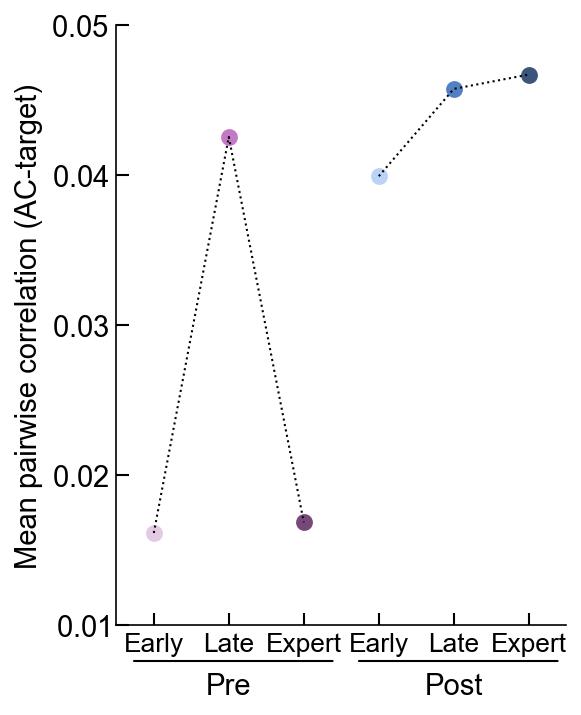

In [72]:
#AC target
stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

#Plot figure

AC_pairwise_target_mean = [AC_mean_target_preearly_corr,AC_mean_target_prelate_corr,AC_mean_target_preexpert_corr,AC_mean_target_postearly_corr,AC_mean_target_postlate_corr,AC_mean_target_postexpert_corr]
print(AC_pairwise_target_mean)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

for idx,column in enumerate(AC_pairwise_target_mean):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],AC_pairwise_target_mean[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],AC_pairwise_target_mean[3:],color='k',linestyle=':',lw=1,alpha=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.01,0.05])
ax.set_yticks([0.01,0.02,0.03,0.04,0.05])
ylab = ax.set_ylabel('Mean pairwise correlation (AC-target)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.ticklabel_format(style='plain', useOffset=False, axis='y') 

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_target_pairwise_corr_learning.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

[0.018255521046787994, 0.04713445691416483, 0.04695426883522533, 0.033471266610732076, 0.03792890273774306, 0.04488380060691635]


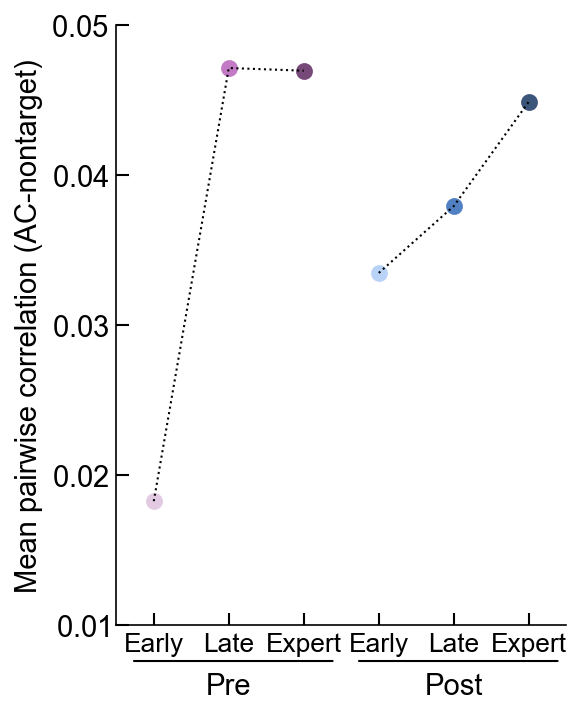

In [73]:
#AC nontarget
stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

#Plot figure

AC_pairwise_nontarget_mean = [AC_mean_nontarget_preearly_corr ,AC_mean_nontarget_prelate_corr,AC_mean_nontarget_preexpert_corr,AC_mean_nontarget_postearly_corr,AC_mean_nontarget_postlate_corr,AC_mean_nontarget_postexpert_corr]
print(AC_pairwise_nontarget_mean)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

for idx,column in enumerate(AC_pairwise_nontarget_mean):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],AC_pairwise_nontarget_mean[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],AC_pairwise_nontarget_mean[3:],color='k',linestyle=':',lw=1,alpha=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.01,0.05])
ax.set_yticks([0.01,0.02,0.03,0.04,0.05])
ylab = ax.set_ylabel('Mean pairwise correlation (AC-nontarget)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.ticklabel_format(style='plain', useOffset=False, axis='y') 

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_nontarget_pairwise_corr_learning.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

[0.05656922189138138, 0.10244118885052808, 0.007051147164796109, 0.04843747258635994, 0.06708376004474947, 0.07460155573792225]


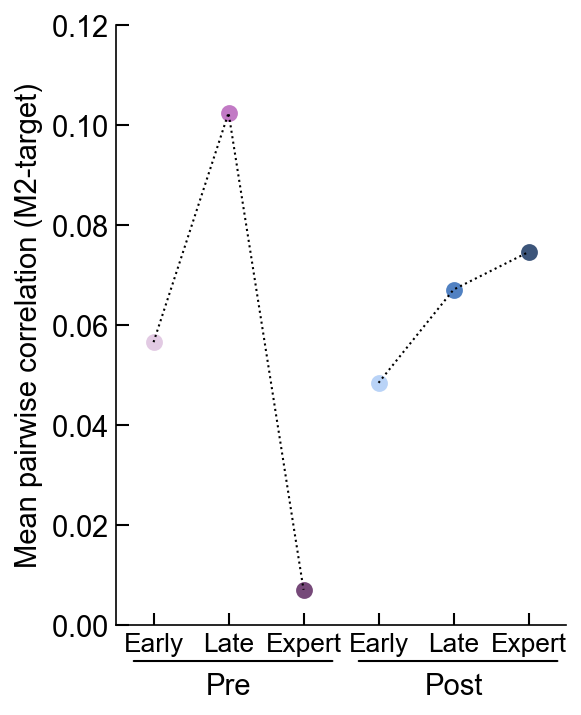

In [70]:
#M2 target

stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

#Plot figure

M2_pairwise_target_mean = [M2_mean_target_preearly_corr ,M2_mean_target_prelate_corr,M2_mean_target_preexpert_corr,M2_mean_target_postearly_corr,M2_mean_target_postlate_corr,M2_mean_target_postexpert_corr]
print(M2_pairwise_target_mean)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

for idx,column in enumerate(M2_pairwise_target_mean):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2],M2_pairwise_target_mean[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],M2_pairwise_target_mean[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,0.12])
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1,0.12])
ylab = ax.set_ylabel('Mean pairwise correlation (M2-target)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.ticklabel_format(style='plain', useOffset=False, axis='y') 

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_target_pairwise_corr_learning.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

[0.07274743352369731, 0.10326162021528235, 0.025021504224152134, 0.05545793631995297, 0.07388682761758963, 0.07185000110190669]


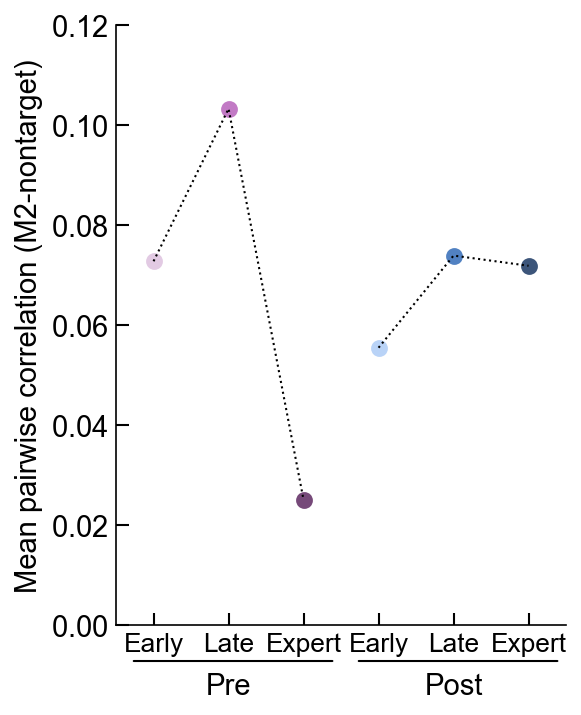

In [74]:
#M2 nontarget

stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

#Plot figure

M2_pairwise_nontarget_mean = [M2_mean_nontarget_preearly_corr ,M2_mean_nontarget_prelate_corr,M2_mean_nontarget_preexpert_corr,M2_mean_nontarget_postearly_corr,M2_mean_nontarget_postlate_corr,M2_mean_nontarget_postexpert_corr]
print(M2_pairwise_nontarget_mean)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

for idx,column in enumerate(M2_pairwise_nontarget_mean):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2,],M2_pairwise_nontarget_mean[:3],color='k',linestyle=':',lw=1,alpha=1)
ax.plot([3,4,5],M2_pairwise_nontarget_mean[3:],color='k',linestyle=':',lw=1,alpha=1)
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,0.12])
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1,0.12])
ylab = ax.set_ylabel('Mean pairwise correlation (M2-nontarget)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.ticklabel_format(style='plain', useOffset=False, axis='y') 

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_nontarget_pairwise_corr_learning.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# Check numbers for cells and pairs

In [31]:
print('check number of pairs:')
print('AC preearly')
for session in AC_preearly:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile_clust = []
    for clust in sessionfile.clusters.good:
        sessionfile_clust.append(clust)
    print('good cluster num: '+str(len(sessionfile_clust)))
    clust_pair = getSessionPairs(sessionfile)
    print(len(clust_pair))
    
print('AC prelate')
for session in AC_prelate:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile_clust = []
    for clust in sessionfile.clusters.good:
        sessionfile_clust.append(clust)
    print('good cluster num: '+str(len(sessionfile_clust)))
    clust_pair = getSessionPairs(sessionfile)
    print(len(clust_pair))
    
print('AC preexpert')
for session in AC_preexpert:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile_clust = []
    for clust in sessionfile.clusters.good:
        sessionfile_clust.append(clust)
    print('good cluster num: '+str(len(sessionfile_clust)))
    clust_pair = getSessionPairs(sessionfile)
    print(len(clust_pair))
    
print('M2 preearly')
for session in M2_preearly:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile_clust = []
    for clust in sessionfile.clusters.good:
        sessionfile_clust.append(clust)
    print('good cluster num: '+str(len(sessionfile_clust)))
    clust_pair = getSessionPairs(sessionfile)
    print(len(clust_pair))
    
print('M2 prelate')
for session in M2_prelate:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile_clust = []
    for clust in sessionfile.clusters.good:
        sessionfile_clust.append(clust)
    print('good cluster num: '+str(len(sessionfile_clust)))
    clust_pair = getSessionPairs(sessionfile)
    print(len(clust_pair))
    
print('M2 preexpert')
for session in M2_preexpert:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    sessionfile_clust = []
    for clust in sessionfile.clusters.good:
        sessionfile_clust.append(clust)
    print('good cluster num: '+str(len(sessionfile_clust)))
    clust_pair = getSessionPairs(sessionfile)
    print(len(clust_pair))

check number of pairs:
AC preearly
good cluster num: 52
1326
good cluster num: 31
465
good cluster num: 27
351
good cluster num: 5
10
good cluster num: 21
210
good cluster num: 12
66
AC prelate
good cluster num: 17
136
good cluster num: 55
1485
good cluster num: 29
406
good cluster num: 8
28
good cluster num: 4
6
good cluster num: 10
45
good cluster num: 4
6
good cluster num: 8
28
good cluster num: 1
0
good cluster num: 2
1
good cluster num: 2
1
good cluster num: 15
105
good cluster num: 6
15
good cluster num: 27
351
AC preexpert
good cluster num: 6
15
good cluster num: 4
6
good cluster num: 19
171
good cluster num: 6
15
good cluster num: 19
171
good cluster num: 12
66
good cluster num: 8
28
good cluster num: 1
0
good cluster num: 27
351
good cluster num: 15
105
M2 preearly
good cluster num: 31
465
good cluster num: 17
136
good cluster num: 18
153
good cluster num: 17
136
good cluster num: 28
378
good cluster num: 33
528
good cluster num: 15
105
M2 prelate
good cluster num: 35
595
good

In [32]:
# 148
# 188
# 117
# 349
# 299
# 285


In [33]:
# 6
# 14
# 10
# 36
# 26
# 31
print(len(AC_preearly_corr))
print(len(AC_prelate_corr))
print(len(AC_preexpert_corr))
print(len(AC_postearly_corr))
print(len(AC_postlate_corr))
print(len(AC_postexpert_corr))
# 7
# 13
# 10
# 19
# 24
# 19
print(len(M2_preearly_corr))
print(len(M2_prelate_corr))
print(len(M2_preexpert_corr))
print(len(M2_postearly_corr))
print(len(M2_postlate_corr))
print(len(M2_postexpert_corr))

6
14
10
36
26
31
7
13
10
19
24
19


In [34]:
#Change the structure

In [35]:
AC_all_preexpert_corr = [corr for session in AC_preexpert_corr for corr in session]
print(len(AC_all_preexpert_corr))
for i in range(len(AC_preexpert_corr)):
    print(len(AC_preexpert_corr[i]))

349
15
3
0
15
36
45
28
0
105
102


In [36]:
AC_all_preearly_corr = [corr for session in AC_preearly_corr for corr in session]
print(len(AC_all_preearly_corr))
for i in range(len(AC_preearly_corr)):
    print(len(AC_preearly_corr[i]))

2376
1316
435
351
0
210
64


In [37]:
AC_all_prelate_corr = [corr for session in AC_prelate_corr for corr in session]
print(len(AC_all_prelate_corr))
for i in range(len(AC_prelate_corr)):
    print(len(AC_prelate_corr[i]))

2450
132
1448
364
28
6
45
6
28
0
0
0
102
15
276


In [38]:
M2_all_preexpert_corr = [corr for session in M2_preexpert_corr for corr in session]
print(len(M2_all_preexpert_corr))
for i in range(len(M2_preexpert_corr)):
    print(len(M2_preexpert_corr[i]))

1520
91
171
15
15
703
0
253
10
171
91


In [39]:
M2_all_preearly_corr = [corr for session in M2_preearly_corr for corr in session]
print(len(M2_all_preearly_corr))
for i in range(len(M2_preearly_corr)):
    print(len(M2_preearly_corr[i]))

1658
402
112
153
0
361
528
102


In [40]:
M2_all_prelate_corr = [corr for session in M2_prelate_corr for corr in session]
print(len(M2_all_prelate_corr))
for i in range(len(M2_prelate_corr)):
    print(len(M2_prelate_corr[i]))

3228
576
979
725
230
291
120
1
0
10
15
150
131
0


In [41]:
AC_all_postearly_corr = [corr for session in AC_postearly_corr for corr in session]
AC_all_postlate_corr = [corr for session in AC_postlate_corr for corr in session]
AC_all_postexpert_corr = [corr for session in AC_postexpert_corr for corr in session]

In [42]:
M2_all_postearly_corr = [corr for session in M2_postearly_corr for corr in session]
M2_all_postlate_corr = [corr for session in M2_postlate_corr for corr in session]
M2_all_postexpert_corr = [corr for session in M2_postexpert_corr for corr in session]

# Plot the histogram

2376
2450
349
6921
2608
1546


C:\Users\insan\AppData\Local\Temp\ipykernel_18160\1849837661.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
meta NOT subset; don't know how to subset; dropped


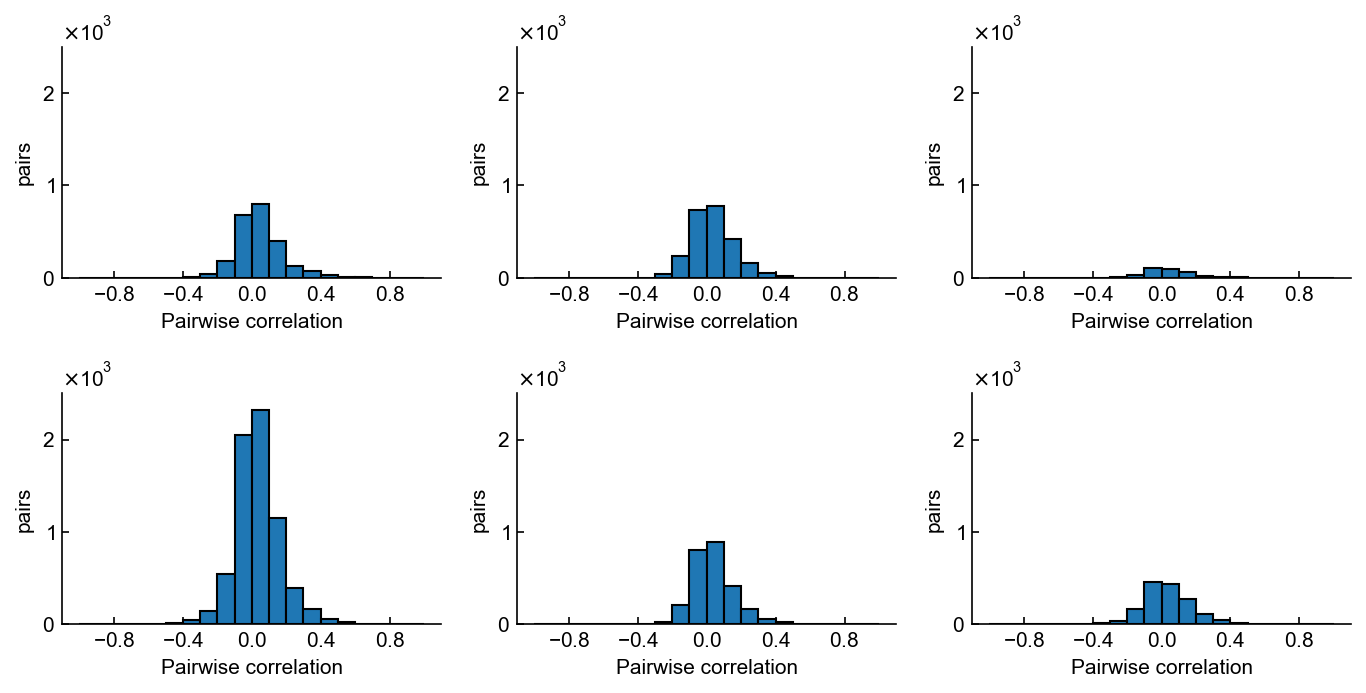

In [80]:
#AC 
print(len(AC_all_preearly_corr))
print(len(AC_all_prelate_corr))
print(len(AC_all_preexpert_corr))

print(len(AC_all_postearly_corr))
print(len(AC_all_postlate_corr))
print(len(AC_all_postexpert_corr))

fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])
num_bins = 20

ax1.hist(AC_all_preearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
ax1.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax1.set_yticks([0,1000,2000])
ax1.set_ylim([0,2500])
ax1.set_xlabel('Pairwise correlation')
ax1.set_ylabel('pairs')

ax2.hist(AC_all_prelate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
ax2.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax2.set_yticks([0,1000,2000])
ax2.set_ylim([0,2500])
ax2.set_xlabel('Pairwise correlation')
ax2.set_ylabel('pairs')

ax3.hist(AC_all_preexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')
ax3.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax3.set_yticks([0,1000,2000])
ax3.set_ylim([0,2500])
ax3.set_xlabel('Pairwise correlation')
ax3.set_ylabel('pairs')

ax4.hist(AC_all_postearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
ax4.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax4.set_yticks([0,1000,2000])
ax4.set_ylim([0,2500])
ax4.set_xlabel('Pairwise correlation')
ax4.set_ylabel('pairs')

ax5.hist(AC_all_postlate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
ax5.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax5.set_yticks([0,1000,2000])
ax5.set_ylim([0,2500])
ax5.set_xlabel('Pairwise correlation')
ax5.set_ylabel('pairs')

ax6.hist(AC_all_postexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')
ax6.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax6.set_yticks([0,1000,2000])
ax6.set_ylim([0,2500])
ax6.set_xlabel('Pairwise correlation')
ax6.set_ylabel('pairs')


plt.tight_layout()
plt.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC correlation.pdf'),transparent=False,facecolor="white")

1658
3228
1520
3683
1450
1761


C:\Users\insan\AppData\Local\Temp\ipykernel_18160\4204169906.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
meta NOT subset; don't know how to subset; dropped


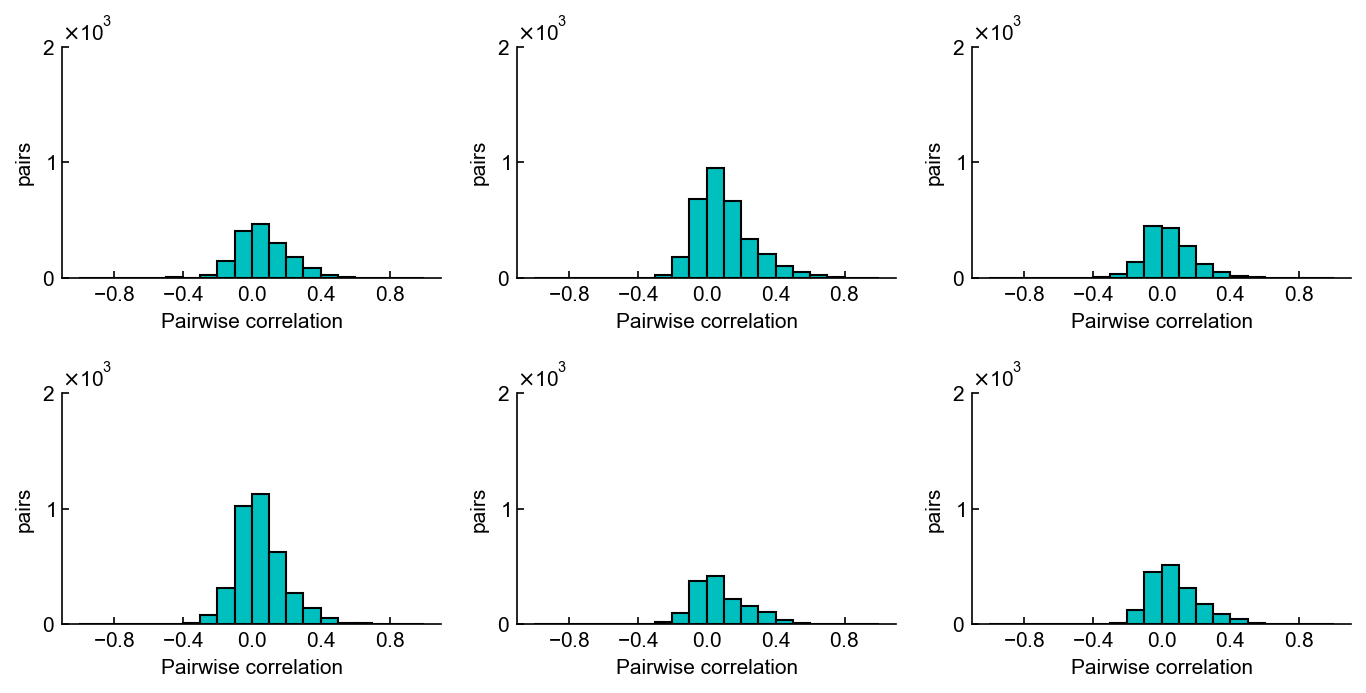

In [81]:
#M2
print(len(M2_all_preearly_corr))
print(len(M2_all_prelate_corr))
print(len(M2_all_preexpert_corr))

print(len(M2_all_postearly_corr))
print(len(M2_all_postlate_corr))
print(len(M2_all_postexpert_corr))

fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])
num_bins = 20

ax1.hist(M2_all_preearly_corr,bins=num_bins,range=(-1,1),color = 'c',edgecolor='k')
ax1.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax1.set_yticks([0,1000,2000])
ax1.set_ylim([0,2000])
ax1.set_xlabel('Pairwise correlation')
ax1.set_ylabel('pairs')

ax2.hist(M2_all_prelate_corr,bins=num_bins,range=(-1,1),color = 'c',edgecolor='k')
ax2.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax2.set_yticks([0,1000,2000])
ax2.set_ylim([0,2000])
ax2.set_xlabel('Pairwise correlation')
ax2.set_ylabel('pairs')

ax3.hist(M2_all_preexpert_corr,bins=num_bins,range=(-1,1),color = 'c',edgecolor='k')
ax3.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax3.set_yticks([0,1000,2000])
ax3.set_ylim([0,2000])
ax3.set_xlabel('Pairwise correlation')
ax3.set_ylabel('pairs')

ax4.hist(M2_all_postearly_corr,bins=num_bins,range=(-1,1),color = 'c',edgecolor='k')
ax4.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax4.set_yticks([0,1000,2000])
ax4.set_ylim([0,2000])
ax4.set_xlabel('Pairwise correlation')
ax4.set_ylabel('pairs')

ax5.hist(M2_all_postlate_corr,bins=num_bins,range=(-1,1),color = 'c',edgecolor='k')
ax5.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax5.set_yticks([0,1000,2000])
ax5.set_ylim([0,2000])
ax5.set_xlabel('Pairwise correlation')
ax5.set_ylabel('pairs')

ax6.hist(M2_all_postexpert_corr,bins=num_bins,range=(-1,1),color = 'c',edgecolor='k')
ax6.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax6.set_yticks([0,1000,2000])
ax6.set_ylim([0,2000])
ax6.set_xlabel('Pairwise correlation')
ax6.set_ylabel('pairs')

plt.tight_layout()
plt.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2 correlation.pdf'),transparent=False,facecolor="white")

# Probability Density Function

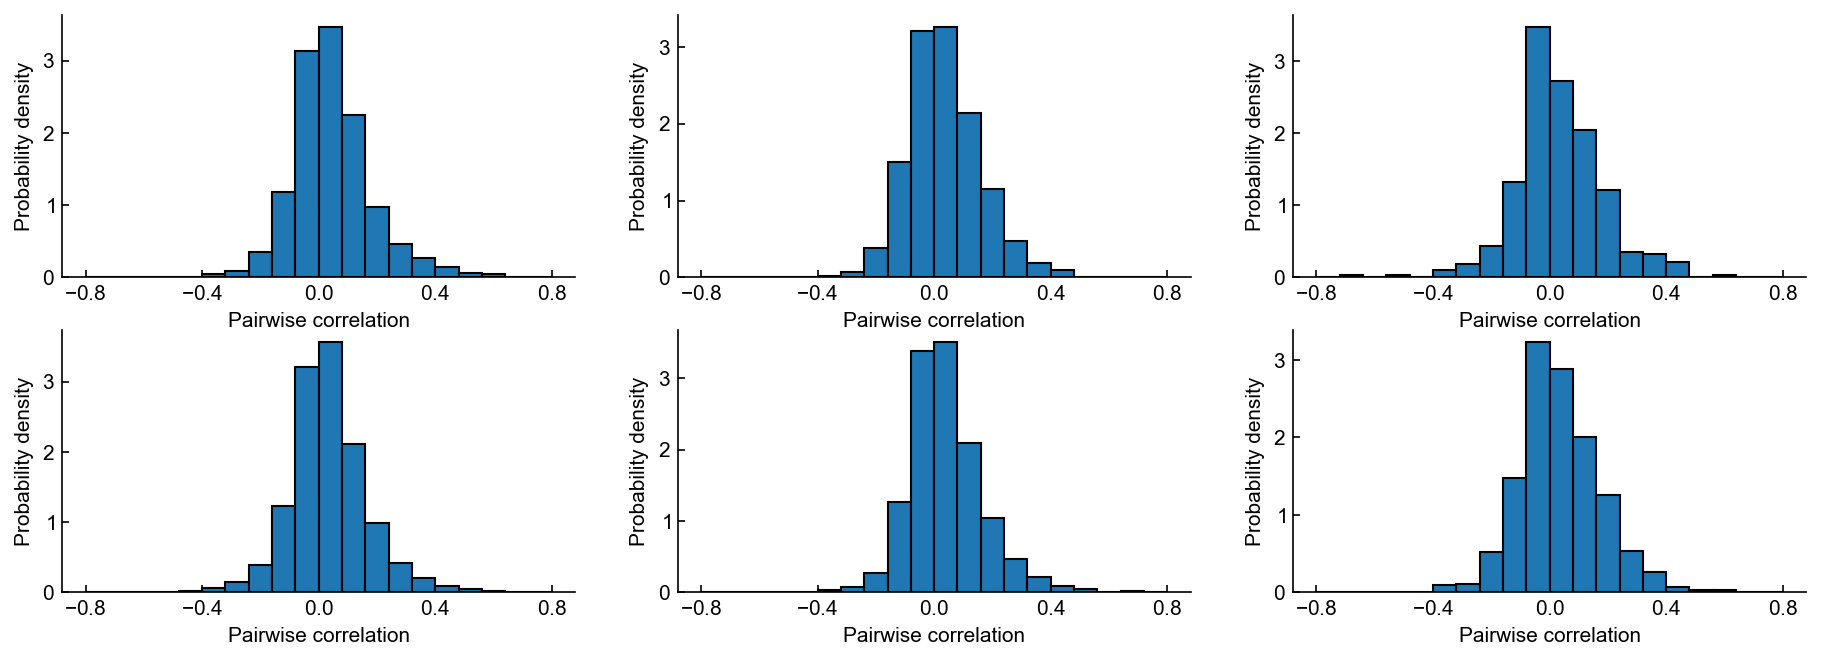

In [101]:
AC_dataset = [AC_all_preearly_corr,AC_all_prelate_corr,AC_all_preexpert_corr,AC_all_postearly_corr,AC_all_postlate_corr,AC_all_postexpert_corr]
labels = ['Pre-early','Pre-late','Pre-expert','Post-early','Post-late','Post-expert']

fig = plt.figure(figsize=(15,5))

for i, data in enumerate(AC_dataset,1):
    plt.subplot(2,3,i)
    plt.hist(data,bins=20,density = True,range=(-0.8,0.8),edgecolor='k')
    plt.xticks([-0.8, -0.4,  0,  0.4,  0.8])
    plt.xlabel('Pairwise correlation')
    plt.ylabel('Probability density')
    #plt.title(labels[i-1])
    
plt.show()

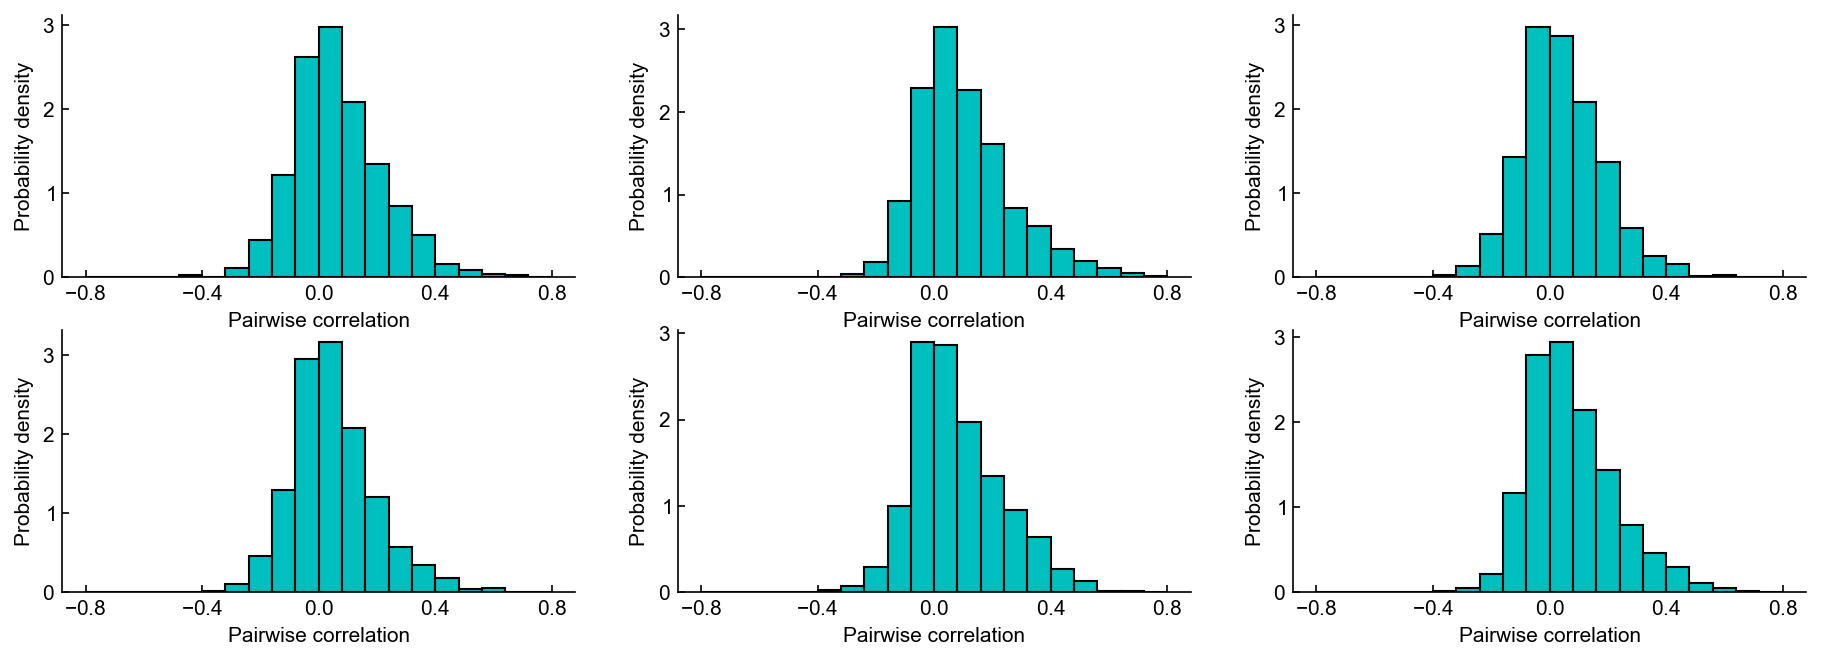

In [98]:
M2_dataset = [M2_all_preearly_corr,M2_all_prelate_corr,M2_all_preexpert_corr,M2_all_postearly_corr,M2_all_postlate_corr,M2_all_postexpert_corr]
labels = ['Pre-early','Pre-late','Pre-expert','Post-early','Post-late','Post-expert']

fig = plt.figure(figsize=(15,5))

for i, data in enumerate(M2_dataset,1):
    plt.subplot(2,3,i)
    plt.hist(data,bins=20,density = True,range=(-0.8,0.8),color = 'c',edgecolor='k')
    plt.xticks([-0.8, -0.4,  0,  0.4,  0.8])
    plt.xlabel('Pairwise correlation')
    plt.ylabel('Probability density')
    
    #plt.title(labels[i-1])
    
plt.show()

# Normalize historgrams

C:\Users\insan\AppData\Local\Temp\ipykernel_18160\1102547704.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
meta NOT subset; don't know how to subset; dropped


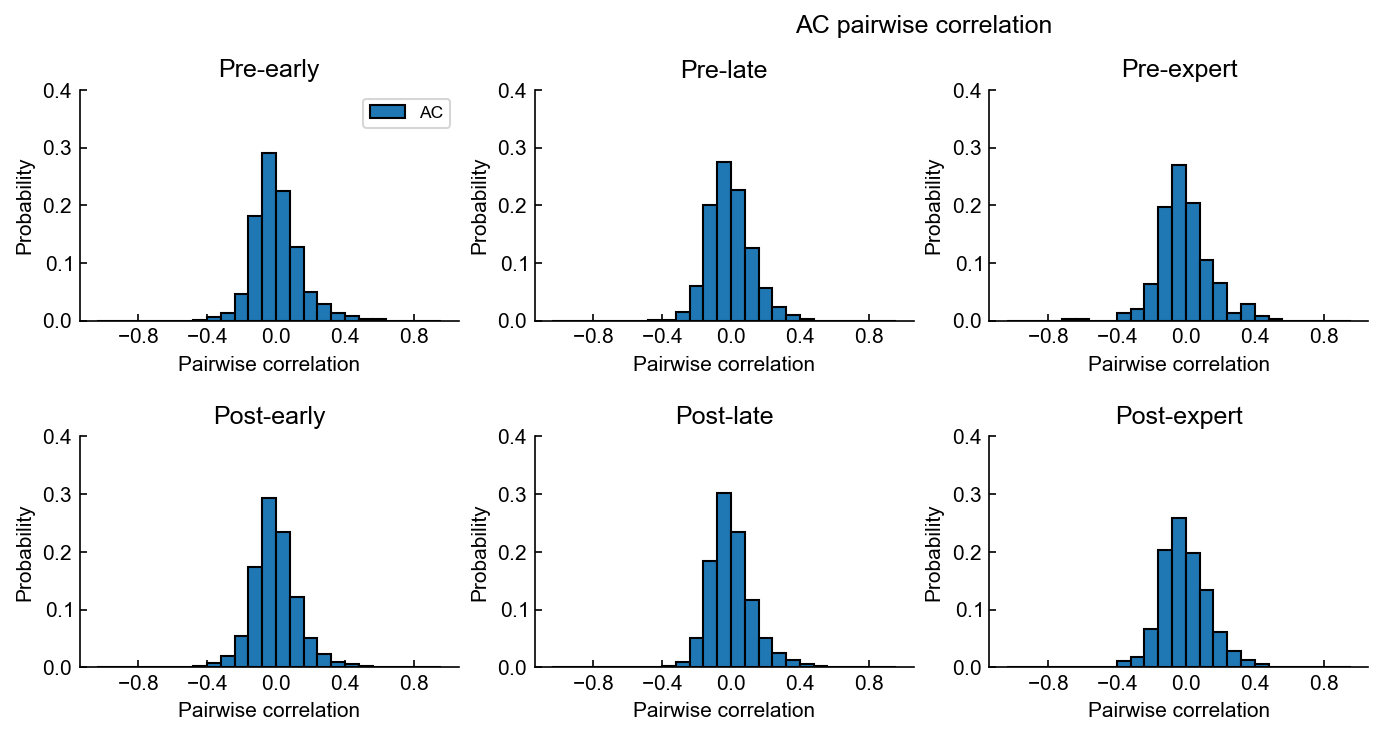

In [259]:
#AC 

num_bins = 25

# hist_AC_preearly, bins_AC_preearly = np.histogram(AC_all_preearly_corr,bins=num_bins)
# normalize_AC_preearly = hist_AC_preearly/hist_AC_preearly.sum()

hist_AC_preearly, bins_AC_preearly, _ = ax1.hist(AC_all_preearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_AC_prelate, bins_AC_prelate, _ = ax2.hist(AC_all_prelate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_AC_preexpert, bins_AC_preexpert, _ = ax3.hist(AC_all_preexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')

hist_AC_postearly, bins_AC_postearly, _ = ax4.hist(AC_all_postearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_AC_postlate, bins_AC_postlate, _ = ax5.hist(AC_all_postlate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_AC_postexpert, bins_AC_postexpert, _ = ax6.hist(AC_all_postexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')



normalize_AC_preearly = hist_AC_preearly/sum(hist_AC_preearly)
normalize_AC_prelate = hist_AC_prelate/sum(hist_AC_prelate)
normalize_AC_preexpert = hist_AC_preexpert/sum(hist_AC_preexpert)
normalize_AC_postearly = hist_AC_postearly/sum(hist_AC_postearly)
normalize_AC_postlate = hist_AC_postlate/sum(hist_AC_postlate)
normalize_AC_postexpert = hist_AC_postexpert/sum(hist_AC_postexpert)

normalize_AC_data = [normalize_AC_preearly,normalize_AC_prelate,normalize_AC_preexpert,normalize_AC_postearly,normalize_AC_postlate,normalize_AC_postexpert]

fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])

ax1.bar(bins_AC_preearly[:-1],normalize_AC_preearly,width=np.diff(bins_AC_preearly),edgecolor='k',label='AC')
ax1.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax1.set_yticks([0,0.1,0.2,0.3,0.4])
ax1.set_ylim([0,0.4])
ax1.set_xlabel('Pairwise correlation')
ax1.set_ylabel('Probability')
ax1.set_title('Pre-early')

ax2.bar(bins_AC_prelate[:-1],normalize_AC_prelate,width=np.diff(bins_AC_prelate),edgecolor='k')
ax2.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax2.set_yticks([0,0.1,0.2,0.3,0.4])
ax2.set_ylim([0,0.4])
ax2.set_xlabel('Pairwise correlation')
ax2.set_ylabel('Probability')
ax2.set_title('Pre-late')

ax3.bar(bins_AC_preexpert[:-1],normalize_AC_preexpert,width=np.diff(bins_AC_preexpert),edgecolor='k')
ax3.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax3.set_yticks([0,0.1,0.2,0.3,0.4])
ax3.set_ylim([0,0.4])
ax3.set_xlabel('Pairwise correlation')
ax3.set_ylabel('Probability')
ax3.set_title('Pre-expert')

ax4.bar(bins_AC_postearly[:-1],normalize_AC_postearly,width=np.diff(bins_AC_postearly),edgecolor='k')
ax4.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax4.set_yticks([0,0.1,0.2,0.3,0.4])
ax4.set_ylim([0,0.4])
ax4.set_xlabel('Pairwise correlation')
ax4.set_ylabel('Probability')
ax4.set_title('Post-early')

ax5.bar(bins_AC_postlate[:-1],normalize_AC_postlate,width=np.diff(bins_AC_postlate),edgecolor='k')
ax5.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax5.set_yticks([0,0.1,0.2,0.3,0.4])
ax5.set_ylim([0,0.4])
ax5.set_xlabel('Pairwise correlation')
ax5.set_ylabel('Probability')
ax5.set_title('Post-late')

ax6.bar(bins_AC_postexpert[:-1],normalize_AC_postexpert,width=np.diff(bins_AC_postexpert),edgecolor='k')
ax6.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax6.set_yticks([0,0.1,0.2,0.3,0.4])
ax6.set_ylim([0,0.4])
ax6.set_xlabel('Pairwise correlation')
ax6.set_ylabel('Probability')
ax6.set_title('Post-expert')

ax1.legend()

plt.suptitle('AC pairwise correlation')

plt.tight_layout()
plt.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC correlation_normalize.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC correlation_normalize.png'),transparent=False,facecolor="white")

C:\Users\insan\AppData\Local\Temp\ipykernel_18160\286540568.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
meta NOT subset; don't know how to subset; dropped


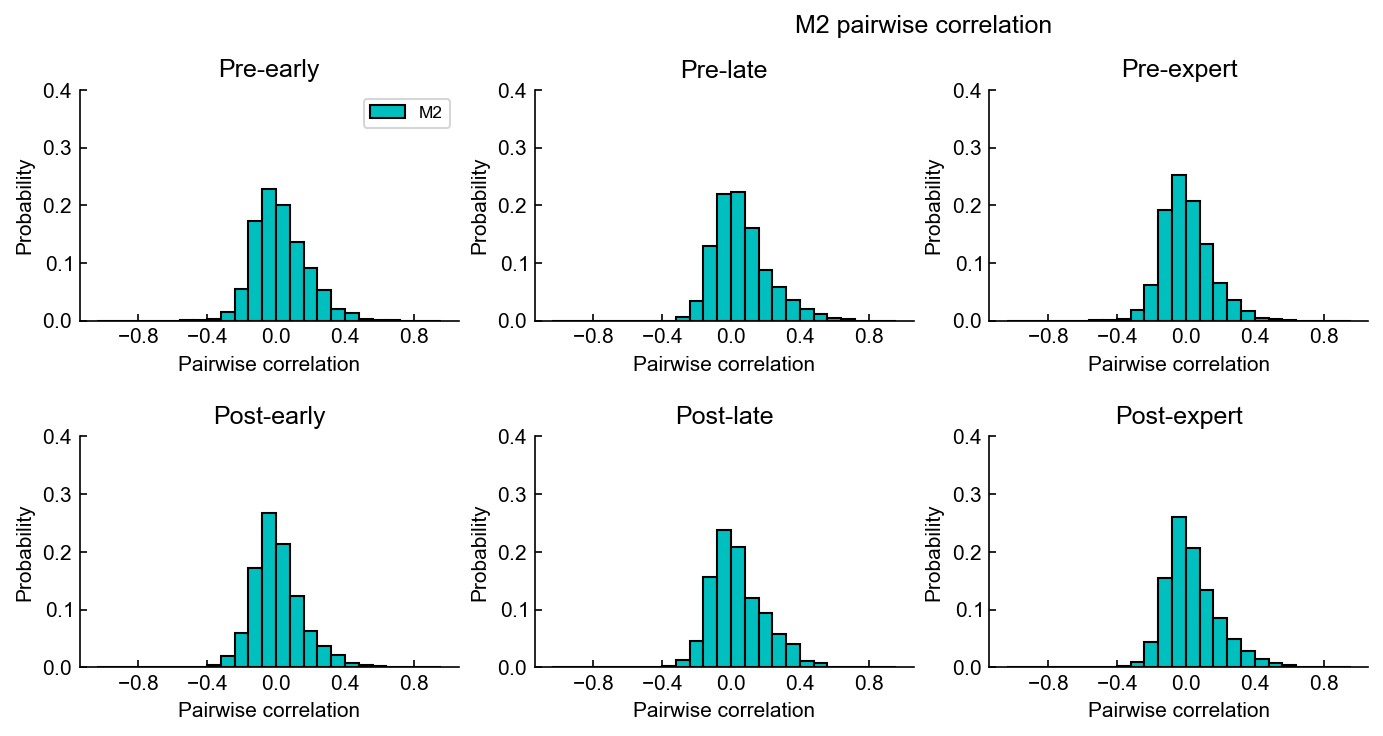

In [258]:
#M2 

num_bins = 25

hist_M2_preearly, bins_M2_preearly, _ = ax1.hist(M2_all_preearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_M2_prelate, bins_M2_prelate, _ = ax2.hist(M2_all_prelate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_M2_preexpert, bins_M2_preexpert, _ = ax3.hist(M2_all_preexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')

hist_M2_postearly, bins_M2_postearly, _ = ax4.hist(M2_all_postearly_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_M2_postlate, bins_M2_postlate, _ = ax5.hist(M2_all_postlate_corr,bins=num_bins,range=(-1,1),edgecolor='k')
hist_M2_postexpert, bins_M2_postexpert, _ = ax6.hist(M2_all_postexpert_corr,bins=num_bins,range=(-1,1),edgecolor='k')

normalize_M2_preearly = hist_M2_preearly/sum(hist_M2_preearly)
normalize_M2_prelate = hist_M2_prelate/sum(hist_M2_prelate)
normalize_M2_preexpert = hist_M2_preexpert/sum(hist_M2_preexpert)
normalize_M2_postearly = hist_M2_postearly/sum(hist_M2_postearly)
normalize_M2_postlate = hist_M2_postlate/sum(hist_M2_postlate)
normalize_M2_postexpert = hist_M2_postexpert/sum(hist_M2_postexpert)

normalize_M2_data = [normalize_M2_preearly,normalize_M2_prelate,normalize_M2_preexpert,normalize_M2_postearly,normalize_M2_postlate,normalize_M2_postexpert]


fig = plt.figure(figsize=(15,5))
gs = fig.add_gridspec(2,4,height_ratios=[0.4,0.4],hspace=0.5)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[0,2])
ax4 = plt.subplot(gs[1,0])
ax5 = plt.subplot(gs[1,1])
ax6 = plt.subplot(gs[1,2])

ax1.bar(bins_M2_preearly[:-1],normalize_M2_preearly,width=np.diff(bins_M2_preearly),color = 'c',edgecolor='k',label='M2')
ax1.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax1.set_yticks([0,0.1,0.2,0.3,0.4])
ax1.set_ylim([0,0.4])
ax1.set_xlabel('Pairwise correlation')
ax1.set_ylabel('Probability')
ax1.set_title('Pre-early')

ax2.bar(bins_M2_prelate[:-1],normalize_M2_prelate,width=np.diff(bins_M2_prelate),color = 'c',edgecolor='k')
ax2.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax2.set_yticks([0,0.1,0.2,0.3,0.4])
ax2.set_ylim([0,0.4])
ax2.set_xlabel('Pairwise correlation')
ax2.set_ylabel('Probability')
ax2.set_title('Pre-late')

ax3.bar(bins_M2_preexpert[:-1],normalize_M2_preexpert,width=np.diff(bins_M2_preexpert),color = 'c',edgecolor='k')
ax3.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax3.set_yticks([0,0.1,0.2,0.3,0.4])
ax3.set_ylim([0,0.4])
ax3.set_xlabel('Pairwise correlation')
ax3.set_ylabel('Probability')
ax3.set_title('Pre-expert')

ax4.bar(bins_M2_postearly[:-1],normalize_M2_postearly,width=np.diff(bins_M2_postearly),color = 'c',edgecolor='k')
ax4.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax4.set_yticks([0,0.1,0.2,0.3,0.4])
ax4.set_ylim([0,0.4])
ax4.set_xlabel('Pairwise correlation')
ax4.set_ylabel('Probability')
ax4.set_title('Post-early')

ax5.bar(bins_M2_postlate[:-1],normalize_M2_postlate,width=np.diff(bins_M2_postlate),color = 'c',edgecolor='k')
ax5.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax5.set_yticks([0,0.1,0.2,0.3,0.4])
ax5.set_ylim([0,0.4])
ax5.set_xlabel('Pairwise correlation')
ax5.set_ylabel('Probability')
ax5.set_title('Post-late')

ax6.bar(bins_M2_postexpert[:-1],normalize_M2_postexpert,width=np.diff(bins_M2_postexpert),color = 'c',edgecolor='k')
ax6.set_xticks([-0.8, -0.4,  0,  0.4,  0.8])
ax6.set_yticks([0,0.1,0.2,0.3,0.4])
ax6.set_ylim([0,0.4])
ax6.set_xlabel('Pairwise correlation')
ax6.set_ylabel('Probability')
ax6.set_title('Post-expert')

plt.suptitle('M2 pairwise correlation')

ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2 correlation_normalize.pdf'),transparent=False,facecolor="white")
plt.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2 correlation_normalize.png'),transparent=False,facecolor="white")

In [160]:
bins_M2_preearly

array([-1.  , -0.92, -0.84, -0.76, -0.68, -0.6 , -0.52, -0.44, -0.36,
       -0.28, -0.2 , -0.12, -0.04,  0.04,  0.12,  0.2 ,  0.28,  0.36,
        0.44,  0.52,  0.6 ,  0.68,  0.76,  0.84,  0.92,  1.  ])

In [161]:
#Remove nan

In [159]:
AC_all_preearly_corr = np.array(AC_all_preearly_corr)
AC_all_prelate_corr = np.array(AC_all_prelate_corr)
AC_all_preexpert_corr = np.array(AC_all_preexpert_corr)
AC_all_postearly_corr = np.array(AC_all_postearly_corr)
AC_all_postlate_corr = np.array(AC_all_postlate_corr)
AC_all_postexpert_corr = np.array(AC_all_postexpert_corr)

AC_all_preearly_corr = AC_all_preearly_corr[~np.isnan(AC_all_preearly_corr)]
AC_all_prelate_corr = AC_all_prelate_corr[~np.isnan(AC_all_prelate_corr)]
AC_all_preexpert_corr = AC_all_preexpert_corr[~np.isnan(AC_all_preexpert_corr)]

AC_all_postearly_corr = AC_all_postearly_corr[~np.isnan(AC_all_postearly_corr)]
AC_all_postlate_corr = AC_all_postlate_corr[~np.isnan(AC_all_postlate_corr)]
AC_all_postexpert_corr = AC_all_postexpert_corr[~np.isnan(AC_all_postexpert_corr)]

In [170]:
M2_all_preearly_corr = np.array(M2_all_preearly_corr)
M2_all_prelate_corr = np.array(M2_all_prelate_corr)
M2_all_preexpert_corr = np.array(M2_all_preexpert_corr)
M2_all_postearly_corr = np.array(M2_all_postearly_corr)
M2_all_postlate_corr = np.array(M2_all_postlate_corr)
M2_all_postexpert_corr = np.array(M2_all_postexpert_corr)

M2_all_preearly_corr = M2_all_preearly_corr[~np.isnan(M2_all_preearly_corr)]
M2_all_prelate_corr = M2_all_prelate_corr[~np.isnan(M2_all_prelate_corr)]
M2_all_preexpert_corr = M2_all_preexpert_corr[~np.isnan(M2_all_preexpert_corr)]

M2_all_postearly_corr = M2_all_postearly_corr[~np.isnan(M2_all_postearly_corr)]
M2_all_postlate_corr = M2_all_postlate_corr[~np.isnan(M2_all_postlate_corr)]
M2_all_postexpert_corr = M2_all_postexpert_corr[~np.isnan(M2_all_postexpert_corr)]

In [217]:
#Create pickle file
AC_pairwise_corr = SimpleNamespace(prereversal_early=AC_all_preearly_corr,
                      prereversal_late=AC_all_prelate_corr,
                      prereversal_expert=AC_all_preexpert_corr,
                      postreversal_early=AC_all_postearly_corr,
                      postreversal_late=AC_all_postlate_corr,
                      postreversal_expert=AC_all_postexpert_corr
                     )

M2_pairwise_corr = SimpleNamespace(prereversal_early=M2_all_preearly_corr,
                      prereversal_late=M2_all_prelate_corr,
                      prereversal_expert=M2_all_preexpert_corr,
                      postreversal_early=M2_all_postearly_corr,
                      postreversal_late=M2_all_postlate_corr,
                      postreversal_expert=M2_all_postexpert_corr
                     )
#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

    filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(M2_pairwise_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

#Load from pickle
with open('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_corr.pickle', "rb") as f:
    AC_pairwise_corr_pickle = pickle.load(f) 
    
with open('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_corr.pickle', "rb") as f:
    M2_pairwise_corr_pickle = pickle.load(f)  

# Calculate std and mean

In [218]:
AC_std_preearly_corr = np.std(AC_all_preearly_corr)
AC_std_prelate_corr = np.std(AC_all_prelate_corr)
AC_std_preexpert_corr = np.std(AC_all_preexpert_corr)
AC_std_postearly_corr = np.std(AC_all_postearly_corr)
AC_std_postlate_corr = np.std(AC_all_postlate_corr)
AC_std_postexpert_corr = np.std(AC_all_postexpert_corr)

AC_mean_preearly_corr = np.mean(AC_all_preearly_corr)
AC_mean_prelate_corr = np.mean(AC_all_prelate_corr)
AC_mean_preexpert_corr = np.mean(AC_all_preexpert_corr)
AC_mean_postearly_corr = np.mean(AC_all_postearly_corr)
AC_mean_postlate_corr = np.mean(AC_all_postlate_corr)
AC_mean_postexpert_corr = np.mean(AC_all_postexpert_corr)

M2_mean_preearly_corr = np.mean(M2_all_preearly_corr)
M2_mean_prelate_corr = np.mean(M2_all_prelate_corr)
M2_mean_preexpert_corr = np.mean(M2_all_preexpert_corr)
M2_mean_postearly_corr = np.mean(M2_all_postearly_corr)
M2_mean_postlate_corr = np.mean(M2_all_postlate_corr)
M2_mean_postexpert_corr = np.mean(M2_all_postexpert_corr)

M2_std_preearly_corr = np.std(M2_all_preearly_corr)
M2_std_prelate_corr = np.std(M2_all_prelate_corr)
M2_std_preexpert_corr = np.std(M2_all_preexpert_corr)
M2_std_postearly_corr = np.std(M2_all_postearly_corr)
M2_std_postlate_corr = np.std(M2_all_postlate_corr)
M2_std_postexpert_corr = np.std(M2_all_postexpert_corr)

In [223]:
AC_pairwise_std = [AC_std_preearly_corr ,AC_std_prelate_corr,AC_std_preexpert_corr,AC_std_postearly_corr,AC_std_postlate_corr,AC_std_postexpert_corr]
AC_pairwise_std

[0.13705392262937258,
 0.12309540918298599,
 0.1504716484994725,
 0.13108530503344798,
 0.12602884116415924,
 0.13799876710709508]

In [224]:
M2_pairwise_std = [M2_std_preearly_corr ,M2_std_prelate_corr,M2_std_preexpert_corr,M2_std_postearly_corr,M2_std_postlate_corr,M2_std_postexpert_corr]
M2_pairwise_std

[0.1542063602020391,
 0.16176788195493336,
 0.14036845172525034,
 0.14641782842421217,
 0.15611336961015507,
 0.1511553597287471]

# Plot correlation along learning

[0.04568545786527215, 0.03547153359689217, 0.032326774984484205, 0.03549967871970227, 0.040864429320544716, 0.034796691589510716]


meta NOT subset; don't know how to subset; dropped


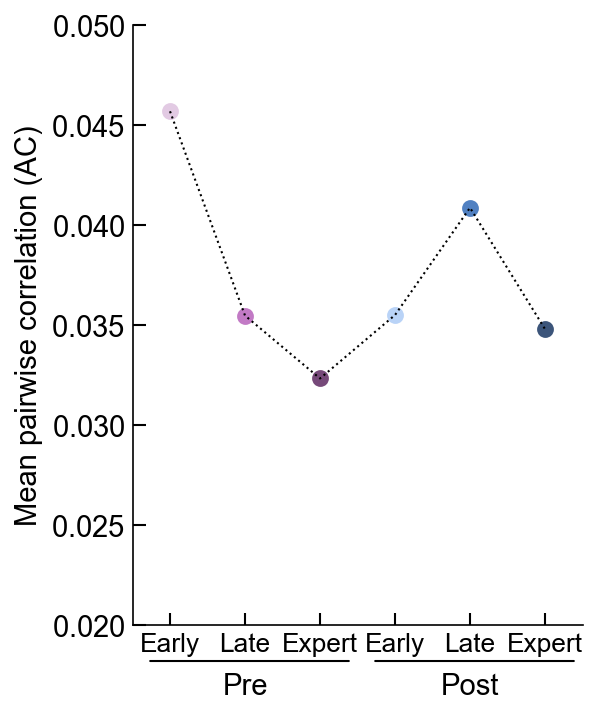

In [256]:
stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

#Plot figure

AC_pairwise_mean = [AC_mean_preearly_corr ,AC_mean_prelate_corr,AC_mean_preexpert_corr,AC_mean_postearly_corr,AC_mean_postlate_corr,AC_mean_postexpert_corr]
print(AC_pairwise_mean)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

for idx,column in enumerate(AC_pairwise_mean):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2,3,4,5],AC_pairwise_mean,color='k',linestyle=':',lw=1,alpha=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0.02,0.05])
ax.set_yticks([0.02,0.025,0.03,0.035,0.04,0.045,0.05])
ylab = ax.set_ylabel('Mean pairwise correlation (AC)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

ax.ticklabel_format(style='plain', useOffset=False, axis='y') 

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_corr_learning.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_corr_learning.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

[0.06676137874356797, 0.10301180508307975, 0.04365090430194626, 0.05224635487441868, 0.080534805978022, 0.07666958888042238]


meta NOT subset; don't know how to subset; dropped


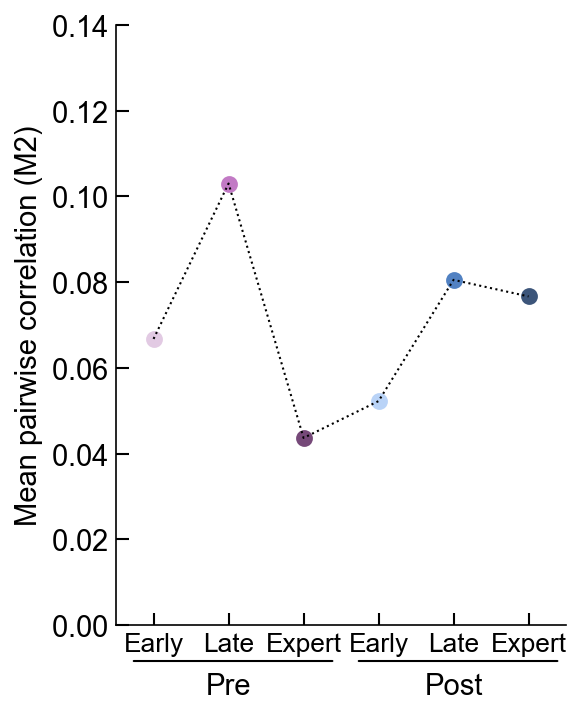

In [257]:
stdfont = 14
stdyfrac = 0.06

def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3, 4, left=.3, bottom=.3, right=0, top=0)

################################################################################################################

#Plot figure

M2_pairwise_mean = [M2_mean_preearly_corr ,M2_mean_prelate_corr,M2_mean_preexpert_corr,M2_mean_postearly_corr,M2_mean_postlate_corr,M2_mean_postexpert_corr]
print(M2_pairwise_mean)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

for idx,column in enumerate(M2_pairwise_mean):
    ax.scatter([idx],column,color=PHASE_COLORS[idx],s=50)
ax.plot([0,1,2,3,4,5],M2_pairwise_mean,color='k',linestyle=':',lw=1,alpha=1)

################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,0.14])
ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1,0.12,0.14])
ylab = ax.set_ylabel('Mean pairwise correlation (M2)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(6))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())#,Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

### Log
# Y = 10**np.mean(np.log10(ax.get_ylim()))
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y*0.45],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y/0.45],lw=1,color=SWITCH_COLOR)

### Linear
# Y = np.mean(ax.get_ylim())
# t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
# ax.plot([2.5]*2,[ax.get_ylim()[0],Y-Y*0.25],lw=1,color=SWITCH_COLOR)
# ax.plot([2.5]*2,[ax.get_ylim()[1],Y+Y*0.25],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]

fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_corr_learning.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_corr_learning.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [ ]:
# Calculate std and mean

In [163]:
AC_std_preearly_corr = np.std(AC_all_preearly_corr)
AC_std_prelate_corr = np.std(AC_all_prelate_corr)
AC_std_preexpert_corr = np.std(AC_all_preexpert_corr)
AC_std_postearly_corr = np.std(AC_all_postearly_corr)
AC_std_postlate_corr = np.std(AC_all_postlate_corr)
AC_std_postexpert_corr = np.std(AC_all_postexpert_corr)

AC_mean_preearly_corr = np.mean(AC_all_preearly_corr)
AC_mean_prelate_corr = np.mean(AC_all_prelate_corr)
AC_mean_preexpert_corr = np.mean(AC_all_preexpert_corr)
AC_mean_postearly_corr = np.mean(AC_all_postearly_corr)
AC_mean_postlate_corr = np.mean(AC_all_postlate_corr)
AC_mean_postexpert_corr = np.mean(AC_all_postexpert_corr)

In [165]:
M2_mean_preearly_corr = np.mean(M2_all_preearly_corr)
M2_mean_prelate_corr = np.mean(M2_all_prelate_corr)
M2_mean_preexpert_corr = np.mean(M2_all_preexpert_corr)
M2_mean_postearly_corr = np.mean(M2_all_postearly_corr)
M2_mean_postlate_corr = np.mean(M2_all_postlate_corr)
M2_mean_postexpert_corr = np.mean(M2_all_postexpert_corr)

M2_std_preearly_corr = np.std(M2_all_preearly_corr)
M2_std_prelate_corr = np.std(M2_all_prelate_corr)
M2_std_preexpert_corr = np.std(M2_all_preexpert_corr)
M2_std_postearly_corr = np.std(M2_all_postearly_corr)
M2_std_postlate_corr = np.std(M2_all_postlate_corr)
M2_std_postexpert_corr = np.std(M2_all_postexpert_corr)

In [167]:
AC_mean_preearly_corr

0.04568545786527215

In [169]:
AC_std_preearly_corr

0.13705392262937258

In [150]:
###################

In [152]:
np.max(AC_all_preearly_corr)

0.725935073189268

In [155]:
np.min(AC_all_preearly_corr)

-0.4729779242661542

In [138]:
abc = np.array(M2_all_preearly_corr)
np.min(abc)

nan

In [119]:
AC_preexpert

['BS_108_1_AC.pickle',
 'BS_108_2_AC.pickle',
 'BS_40_12_AC.pickle',
 'BS_49_12_AC.pickle',
 'BS_72_1_AC.pickle',
 'BS_72_2_AC.pickle',
 'BS_87_1_AC.pickle',
 'BS_87_2_AC.pickle',
 'DS_15_1_AC.pickle',
 'DS_19_1_AC.pickle']

In [127]:
sessionfile = ilep.loadSessionCached(act_directory,AC_preexpert[-3])

sessionfile_clust = []
for clust in sessionfile.clusters.good:
    sessionfile_clust.append(clust)
    
# cluster_pairs = getSessionPairs(sessionfile)
# print(len(cluster_pairs))

# session_corr = []

# for clust_pair in cluster_pairs:
#     clustA = clust_pair[0]
#     clustB = clust_pair[1]


#     trials_to_use = getTrialsforPair(sessionfile,clustA,clustB)
#     print(trials_to_use)

#     if len(trials_to_use) !=0:
#         #calculate spike count residual for each cell in this pair
#         res_spike_count_trials_A = countClustSpikes_alltrials(sessionfile,clustA,window_length,trials_to_use)[2]
#         res_spike_count_trials_B = countClustSpikes_alltrials(sessionfile,clustB,window_length,trials_to_use)[2]

#         #calculate the pearson correlation between this pair
#         corr = stats.pearsonr(res_spike_count_trials_A,res_spike_count_trials_B)[0]
#         session_corr.append(corr)

In [28]:
#Example hist plot

Text(0.5, 1.0, 'AC preearly correlation')

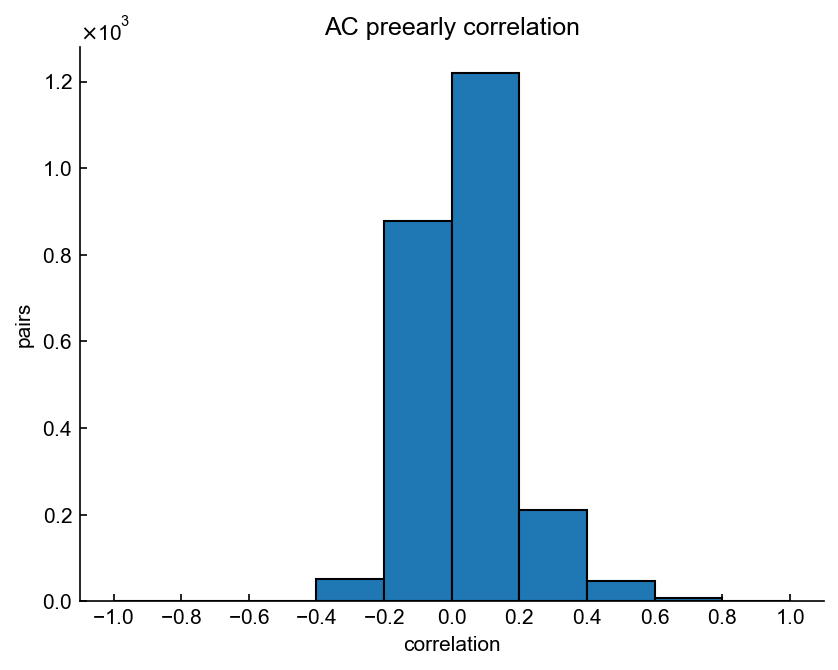

In [58]:
plotdata = AC_all_preearly_corr
num_bins = 10
plt.hist(plotdata,bins=num_bins,range=(-1,1),edgecolor='k')
plt.xticks([-1, -0.8, -0.6, -0.4, -0.2,  0,  0.2,  0.4,  0.6,  0.8,  1])
plt.xlabel('correlation')
plt.ylabel('pairs')
plt.title('AC preearly correlation')

In [147]:
#Example of sessions from one learning phase (AC)

In [ ]:
for session in AC_preearly:
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    cluster_pairs = getSessionPairs(sessionfile)
    
    session_corr = []
    session_trial = []
    #For each pair, get trials to use, calculate spike count residual for each cell in this pair, then calculate the pearson correlation
    for clust_pair in cluster_pairs:
        #For each pair
        clustA = clust_pair[0]
        clustB = clust_pair[1]

        #Get trials to use
        trials_to_use = getTrialsforPair(sessionfile,clustA,clustB)
        
        if len(trials_to_use) !=0:
            #calculate spike count residual for each cell in this pair
            res_spike_count_trials_A = countClustSpikes_alltrials(sessionfile,clustA,window_length,trials_to_use)[2]
            res_spike_count_trials_B = countClustSpikes_alltrials(sessionfile,clustB,window_length,trials_to_use)[2]

            #calculate the pearson correlation between this pair
            corr = stats.pearsonr(res_spike_count_trials_A,res_spike_count_trials_B)
            session_corr.append(corr)
            
    AC_preearly_corr.append(session_corr)

In [80]:
#Example for a session

In [22]:
#Define sessionfile and get good clusters from this sessionfile
sessionfile = ilep.loadSessionCached(act_directory,EnumACSession[0])
sessionfile.meta


namespace(directory='D:\\DualRecording\\BS_108\\BS_108 1\\AC\\',
          region='AC',
          animal='BS_108',
          probe=6927,
          date='3/22/2022',
          depth=870,
          task='nonreversal',
          day_of_training=5,
          day_of_recording=1,
          length_in_samples=68952017.0,
          files=['March 22 2022 Dual BS_108_1001',
                 'March 22 2022 Dual BS_108_1002',
                 'March 22 2022 Dual BS_108_1003'],
          behavior='expert',
          condition='prereversal expert',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=2298.4005666666667,
          length_in_minutes=38.30667611111111,
          length_in_trials=480)

In [23]:
#get good clusters from this sessionfile
# sessionfile_clust = []
# for clust in sessionfile.clusters.good:
#     sessionfile_clust.append(clust)
    


In [24]:
# #Get all pairs from this session
# cluster_pairs = [(sessionfile_clust[i],sessionfile_clust[j]) for i in range(len(sessionfile_clust)) for j in range(i+1,len(sessionfile_clust))]

cluster_pairs = getSessionPairs(sessionfile)

In [25]:
cluster_pairs

[(2, 8),
 (2, 9),
 (2, 14),
 (2, 34),
 (2, 35),
 (8, 9),
 (8, 14),
 (8, 34),
 (8, 35),
 (9, 14),
 (9, 34),
 (9, 35),
 (14, 34),
 (14, 35),
 (34, 35)]

In [26]:
session_corr = []
#For each pair, get trials to use, calculate spike count residual for each cell in this pair, then calculate the pearson correlation
for clust_pair in cluster_pairs:
    #For each pair
    clustA = clust_pair[0]
    clustB = clust_pair[1]
    
    #Get trials to use
    trials_to_use = getTrialsforPair(sessionfile,clustA,clustB)
   
    #calculate spike count residual for each cell in this pair
    res_spike_count_trials_A = countClustSpikes_alltrials(sessionfile,clustA,window_length,trials_to_use)[2]
    res_spike_count_trials_B = countClustSpikes_alltrials(sessionfile,clustB,window_length,trials_to_use)[2]
    
    #calculate the pearson correlation between this pair
    corr = stats.pearsonr(res_spike_count_trials_A,res_spike_count_trials_B)
    
    session_corr.append(corr)

121
121
121
121
121
121
121
121
121
121
124
124
121
121
124
124
124
124
121
121
124
124
124
124
121
121
121
121
124
124


In [30]:
session_corr

[(0.20258497570765757, 0.025849595417477528),
 (0.09344543515520423, 0.3079832792816254),
 (0.36099383736762436, 4.7468054651445275e-05),
 (0.3291592645588995, 0.00022740779238393624),
 (0.29215635746859525, 0.0011475429359691738),
 (-0.15820686291218167, 0.07926872850069715),
 (0.4538489376842359, 1.7118259589230804e-07),
 (0.20402213053233687, 0.02303540166244786),
 (0.11543802183679235, 0.20170201654119857),
 (0.3718569268134339, 2.6740732235643587e-05),
 (0.24757827860186776, 0.005566332829056163),
 (0.42261333009386964, 1.0112230436322046e-06),
 (0.20445757092256736, 0.02448025633815404),
 (0.43951146912214883, 4.569949684659682e-07),
 (0.20719471615624413, 0.020945173607950375)]

In [31]:
#example for one cluster
sessionfile = ilep.loadSessionCached(act_directory,EnumACSession[0])
sessionfile.meta


namespace(directory='D:\\DualRecording\\BS_108\\BS_108 1\\AC\\',
          region='AC',
          animal='BS_108',
          probe=6927,
          date='3/22/2022',
          depth=870,
          task='nonreversal',
          day_of_training=5,
          day_of_recording=1,
          length_in_samples=68952017.0,
          files=['March 22 2022 Dual BS_108_1001',
                 'March 22 2022 Dual BS_108_1002',
                 'March 22 2022 Dual BS_108_1003'],
          behavior='expert',
          condition='prereversal expert',
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=2298.4005666666667,
          length_in_minutes=38.30667611111111,
          length_in_trials=480)

In [73]:
sessionfile_clust = []
for clust in sessionfile.clusters.good:
    sessionfile_clust.append(clust)
    countClustSpikes_alltrials(sessionfile,clust,window_length)[0]

121
121
121
121
124
124
124
124
124
124
124
124
121
121
121
121
124
124
124
124
124
124
124
124


In [47]:
sessionfile_clust

[2, 8, 9, 14, 34, 35]

In [74]:
trials_to_use = ilep.getAllConditions(sessionfile,sessionfile_clust[-2],trialsPerDayLoaded=None)['all_trials']

In [75]:
trials_to_use.trials

array([330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,
       421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
       434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 451, 452, 453])

In [76]:
trials_to_use = ilep.getAllConditions(sessionfile,sessionfile_clust[-1],trialsPerDayLoaded=None)['all_trials']

In [77]:
trials_to_use = ilep.getAllConditions(sessionfile,sessionfile_clust[-1],trialsPerDayLoaded=None)['all_trials']
trials_to_use.trials

array([330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,
       421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
       434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 451, 452, 453])

In [78]:
clust = sessionfile_clust[-1]
exampleA_spike_count = countClustSpikes_alltrials(sessionfile,clust,window_length)[0]
exampleA_mean = countClustSpikes_alltrials(sessionfile,clust,window_length)[1]
exampleA_res_count = countClustSpikes_alltrials(sessionfile,clust,window_length)[2]


124
124
124
124
124
124
124
124
124
124
124
124


In [79]:
clust = sessionfile_clust[-2]
exampleB_spike_count = countClustSpikes_alltrials(sessionfile,clust,window_length)[0]
exampleB_mean = countClustSpikes_alltrials(sessionfile,clust,window_length)[1]
exampleB_res_count = countClustSpikes_alltrials(sessionfile,clust,window_length)[2]


124
124
124
124
124
124
124
124
124
124
124
124


In [99]:
stats.pearsonr(exampleA_res_count,exampleB_res_count)

(0.20719471615624413, 0.020945173607950375)

In [100]:
stats.pearsonr(exampleA_spike_count,exampleB_spike_count)

(0.20719471615624413, 0.020945173607950375)

In [91]:
exampleB_res_count

array([ 0.53225806, -0.46774194,  1.53225806, -2.46774194, -2.46774194,
        0.53225806,  1.53225806, -2.46774194,  2.53225806,  0.53225806,
       -2.46774194,  0.53225806, -0.46774194, -2.46774194,  3.53225806,
       -1.46774194, -2.46774194, -1.46774194, -0.46774194, -0.46774194,
        0.53225806,  2.53225806, -1.46774194, -1.46774194, -2.46774194,
       -1.46774194, -2.46774194, -2.46774194,  0.53225806, -2.46774194,
       -2.46774194,  0.53225806, -1.46774194, -2.46774194, -2.46774194,
        5.53225806,  0.53225806,  0.53225806, -2.46774194,  0.53225806,
       -1.46774194, -2.46774194,  2.53225806, -2.46774194,  0.53225806,
       -2.46774194, -1.46774194,  0.53225806, -1.46774194,  2.53225806,
       -0.46774194, -1.46774194,  0.53225806,  0.53225806,  1.53225806,
       -0.46774194, -0.46774194, -1.46774194, -2.46774194, -2.46774194,
        2.53225806,  2.53225806,  0.53225806, -0.46774194, -1.46774194,
       -2.46774194, -2.46774194, -2.46774194, -0.46774194, -2.46

In [90]:
exampleA_res_count

array([-0.80645161, -0.80645161, -0.80645161, -1.80645161, -1.80645161,
       -1.80645161,  1.19354839, -1.80645161, -1.80645161, -1.80645161,
        1.19354839, -1.80645161, -1.80645161, -1.80645161, -0.80645161,
       -0.80645161, -1.80645161, -1.80645161,  2.19354839, -1.80645161,
        2.19354839, -1.80645161, -1.80645161, -1.80645161, -0.80645161,
        0.19354839, -1.80645161, -0.80645161, -1.80645161, -0.80645161,
       -1.80645161, -1.80645161, -0.80645161, -1.80645161,  0.19354839,
        3.19354839, -0.80645161,  0.19354839, -1.80645161,  0.19354839,
       -1.80645161, -0.80645161,  3.19354839, -1.80645161,  0.19354839,
       -1.80645161, -1.80645161, -0.80645161, -0.80645161,  0.19354839,
       -0.80645161, -0.80645161, -0.80645161,  1.19354839, -1.80645161,
        1.19354839,  5.19354839, -1.80645161, -1.80645161, -1.80645161,
        8.19354839,  0.19354839,  1.19354839,  1.19354839,  0.19354839,
       -1.80645161,  2.19354839, -1.80645161, -0.80645161,  1.19

In [104]:
trials_to_use_A = ilep.getAllConditions(sessionfile,sessionfile_clust[-1])['all_trials']
trials_to_use_A.trials

array([330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,
       421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
       434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
       447, 448, 449, 450, 451, 452, 453])

In [105]:
trials_to_use_C = ilep.getAllConditions(sessionfile,sessionfile_clust[0])['all_trials']
trials_to_use_C.trials

array([330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,
       421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
       434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
       447, 448, 449, 450])

In [107]:
np.intersect1d(trials_to_use_A.trials,trials_to_use_C.trials)

array([330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,
       421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
       434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
       447, 448, 449, 450])

In [116]:
getTrialsforPair(sessionfile,sessionfile_clust[0],sessionfile_clust[-1])


121
124
121


array([330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342,
       343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355,
       356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368,
       369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381,
       382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394,
       395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407,
       408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420,
       421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433,
       434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446,
       447, 448, 449, 450])

In [120]:
sessionfile_clust

[2, 8, 9, 14, 34, 35]

In [121]:

cluster_pairs = [(sessionfile_clust[i],sessionfile_clust[j]) for i in range(len(sessionfile_clust)) for j in range(i+1,len(sessionfile_clust))]

In [122]:
cluster_pairs

[(2, 8),
 (2, 9),
 (2, 14),
 (2, 34),
 (2, 35),
 (8, 9),
 (8, 14),
 (8, 34),
 (8, 35),
 (9, 14),
 (9, 34),
 (9, 35),
 (14, 34),
 (14, 35),
 (34, 35)]

# FR Mod

C:\Users\insan\AppData\Local\Temp\ipykernel_21500\642380571.py:14: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)


baseline = 3.5533237685317998


meta NOT subset; don't know how to subset; dropped


148
188
117
349
299
285


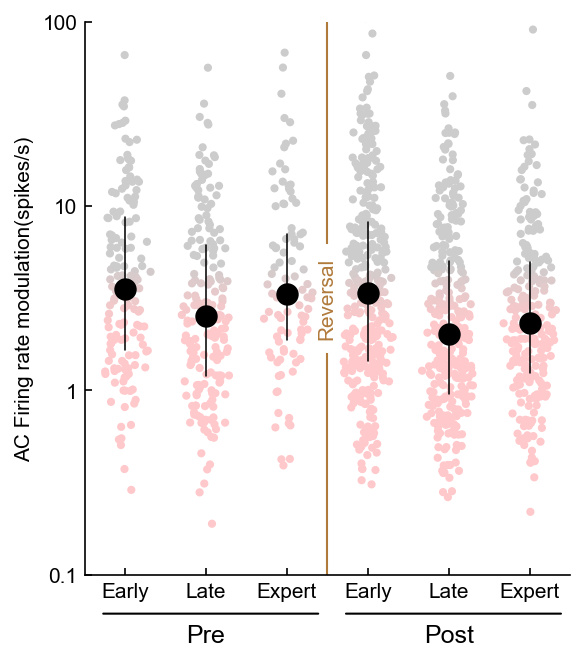

In [15]:
size=10

FRmod_baseline_median = np.median(FRmod_preearly_AC)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly_AC,FRmod_prelate_AC,FRmod_preexpert_AC,FRmod_postearly_AC,FRmod_postlate_AC,FRmod_postexpert_AC]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)

mn = 3.5
spread = 2.5
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.75,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
#     border_color = NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    eye_color='k'
    border_color='k'#'#202020'#colorsys.hls_to_rgb(h,l*0.8,s)
#     print(border_color)

    summary_size=100
    summary_width=0.75
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    
#Connected lines
# medians = [np.nanmedian(d) for d in data]
# ax.plot([0,1,2],medians[0:3],linestyle='--',color=GOOD_GREY,lw=1)
# ax.plot([3,4,5],medians[3:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('AC Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#bax.axs[0].text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
size = 5
rev = 2.5
center = 10**(0.5)#center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center/2],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center*2,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.60,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 0.054188468134356925, 'Post', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

plt.tight_layout()
plt.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\AC Frining rate modulation.pdf'),transparent=False,facecolor="white")
print(len(FRmod_preearly_AC))
print(len(FRmod_prelate_AC))
print(len(FRmod_preexpert_AC))
print(len(FRmod_postearly_AC))
print(len(FRmod_postlate_AC))
print(len(FRmod_postexpert_AC))

baseline = 2.3406478578892433


C:\Users\insan\AppData\Local\Temp\ipykernel_21500\1661158452.py:14: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)
meta NOT subset; don't know how to subset; dropped


159
240
199
349
204
218


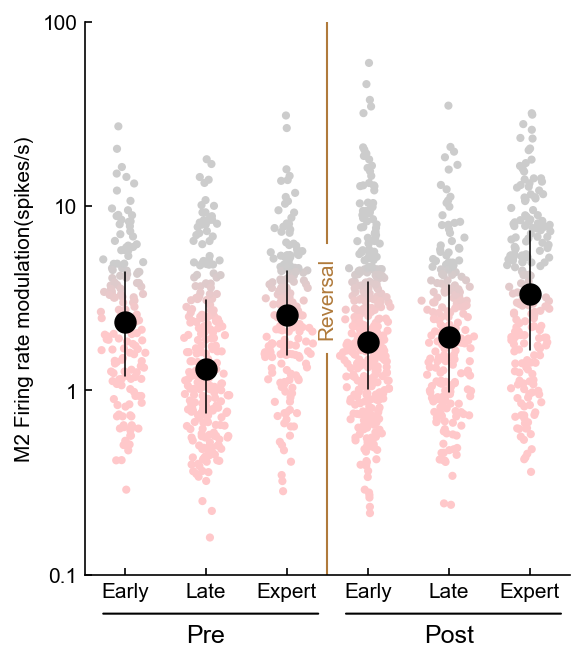

In [16]:
size=10

FRmod_baseline_median = np.median(FRmod_preearly_M2)
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly_M2,FRmod_prelate_M2,FRmod_preexpert_M2,FRmod_postearly_M2,FRmod_postlate_M2,FRmod_postexpert_M2]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)

X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.75,minjitter=0.075)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.75,minjitter=0.075)

mn = 3.5
spread = 2.5
colors = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

ax.scatter(X, Y, s=size, ec=colors, fc=colors, lw=0.75,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    column = ilep.rmnan(column)
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color= NCR_CR_cmap((percentCR-40)/20)
#     border_color = NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    eye_color='k'
    border_color='k'#'#202020'#colorsys.hls_to_rgb(h,l*0.8,s)
#     print(border_color)

    summary_size=100
    summary_width=0.75
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
#     median = np.mean(column)
#     Q1 = median - sem(column)
#     Q1 = median + sem(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

    
#Connected lines
# medians = [np.nanmedian(d) for d in data]
# ax.plot([0,1,2],medians[0:3],linestyle='--',color=GOOD_GREY,lw=1)
# ax.plot([3,4,5],medians[3:6],linestyle='--',color=GOOD_GREY,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('M2 Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#bax.axs[0].text(reversal,ax.get_ylim()[1]+0.2,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='top')
size = 5
rev = 2.5
center = 10**(0.5)#center = np.mean(ax.get_ylim())
ax.text(rev,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
ax.plot([rev,rev],[ax.get_ylim()[0],center/2],color=SWITCH_COLOR,lw=1,linestyle='-')
ax.plot([rev,rev],[center*2,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.60,zorder=-5)

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.054188468134356925, 'Pre', ha='center', va='top', fontsize=12,color='k')
ax.text(xtick_pos_post, 0.054188468134356925, 'Post', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='k'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='k'))

plt.tight_layout()
plt.savefig(os.path.join('C:\\Users\insan\\Desktop\\Dual_Analysis\\M2 Frining rate modulation.pdf'),transparent=False,facecolor="white")

print(len(FRmod_preearly_M2))
print(len(FRmod_prelate_M2))
print(len(FRmod_preexpert_M2))
print(len(FRmod_postearly_M2))
print(len(FRmod_postlate_M2))
print(len(FRmod_postexpert_M2))

In [17]:
def nonparametricIndependentStatsCompareToOwnEarly(data):
	'''
	Data should be a SimpleNamespace with six fields within it labeled ['preearly','prelate','preexpert','postearly','postlate','postexpert']
	'''

	### Create dataframe ###
	phase = len(data.preearly)*["pre-late"] + len(data.prelate)*["pre-late"] \
		    + len(data.preearly)*["pre-expert"] + len(data.preexpert)*["pre-expert"] \
	        + len(data.postearly)*["post-late"] + len(data.postlate)*["post-late"] \
	        + len(data.postearly)*["post-expert"] + len(data.postexpert)*["post-expert"]


	context = len(data.preearly)*["baseline"] + len(data.prelate)*["experimental"] \
		    + len(data.preearly)*["baseline"] + len(data.preexpert)*["experimental"] \
	        + len(data.postearly)*["baseline"] + len(data.postlate)*["experimental"] \
	        + len(data.postearly)*["baseline"] + len(data.postexpert)*["experimental"]

	mod = (np.concatenate([data.preearly, data.prelate,
			data.preearly, data.preexpert,
			data.postearly, data.postlate,
			data.postearly, data.postexpert]))

	df = pd.DataFrame({"phase": phase, "context": context, "FR_mod": mod})



	### Anova ###
	anova = pg.anova(data=df, dv='FR_mod', between=['phase','context'], detailed=True)
	print(anova)
	print()



	### Create and print results ###
	pairwise_mwu = pg.pairwise_tests(data=df, dv='FR_mod', between=['phase','context'], padjust="fdr_bh", parametric=False, )
	print(pairwise_mwu[pairwise_mwu["Contrast"] == "phase * context"][["phase","A", "B", "p-unc", "p-corr", "hedges"]])
	return pairwise_mwu

In [18]:
data_M2 = [FRmod_preearly_M2,FRmod_prelate_M2,FRmod_preexpert_M2,FRmod_postearly_M2,FRmod_postlate_M2,FRmod_postexpert_M2]

FRM2Data = SimpleNamespace()
FRM2Data.preearly = FRmod_preearly_M2
FRM2Data.prelate = FRmod_prelate_M2
FRM2Data.preexpert = FRmod_preexpert_M2
FRM2Data.postearly = FRmod_postearly_M2
FRM2Data.postlate = FRmod_postlate_M2
FRM2Data.postexpert = FRmod_postexpert_M2

In [19]:
nonparametricIndependentStatsCompareToOwnEarly(FRM2Data)

            Source            SS      DF          MS         F     p-unc  \
0            phase    466.463127     3.0  155.487709  6.542837  0.000212   
1          context      9.332056     1.0    9.332056  0.392688  0.530968   
2  phase * context    479.938932     3.0  159.979644  6.731855  0.000163   
3         Residual  43655.516488  1837.0   23.764571       NaN       NaN   

        np2  
0  0.010572  
1  0.000214  
2  0.010874  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  1.483488e-07  5.933951e-07 -0.285835
8     post-late  baseline  experimental  8.805237e-01  8.805237e-01  0.092437
9    pre-expert  baseline  experimental  2.805952e-01  3.741269e-01 -0.031084
10     pre-late  baseline  experimental  1.608033e-05  3.216065e-05  0.305536


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,168290.5,two-sided,3.149442e-03,4.724163e-03,fdr_bh,0.141815
1,phase,-,post-expert,pre-expert,False,False,93058.0,two-sided,7.223070e-01,7.223070e-01,fdr_bh,0.135330
2,phase,-,post-expert,pre-late,False,False,128046.0,two-sided,1.293806e-05,3.881417e-05,fdr_bh,0.276484
3,phase,-,post-late,pre-expert,False,False,82342.5,two-sided,1.146513e-03,2.293027e-03,fdr_bh,-0.019084
4,phase,-,post-late,pre-late,False,False,117541.5,two-sided,7.290596e-02,8.748715e-02,fdr_bh,0.126907
5,phase,-,pre-expert,pre-late,False,False,80982.0,two-sided,8.285622e-06,3.881417e-05,fdr_bh,0.188233
6,context,-,baseline,experimental,False,False,411454.0,two-sided,3.952217e-01,NaN,NaN,0.001939
7,phase * context,post-expert,baseline,experimental,False,False,25928.5,two-sided,1.483488e-07,5.933951e-07,fdr_bh,-0.285835
8,phase * context,post-late,baseline,experimental,False,False,35871.0,two-sided,8.805237e-01,8.805237e-01,fdr_bh,0.092437
9,phase * context,pre-expert,baseline,experimental,False,False,13564.0,two-sided,2.805952e-01,3.741269e-01,fdr_bh,-0.031084


In [40]:
sessionfile.meta

namespace(directory='D:\\DualRecording\\DS_19\\DS_19 9\\AC\\',
          region='AC',
          animal='DS_19',
          probe=6928,
          date='05/04/2021',
          depth=1300,
          task='reversal',
          day_of_training=19,
          day_of_recording=9,
          day_of_reversal=8,
          length_in_samples=99398253.0,
          files=['May 4 2021 Dual DS_19_9001',
                 'May 4 2021 Dual DS_19_9002',
                 'May 4 2021 Dual DS_19_9003',
                 'May 4 2021 Dual DS_19_9004',
                 'May 4 2021 Dual DS_19_9005'],
          arraystart=0,
          tonelength=0.1,
          triallength=2.5,
          lickdelayrelativetostart=0.2,
          lickdelayrelativetotone=0.1,
          fs=30000,
          length_in_seconds=3313.2751,
          length_in_minutes=55.22125166666667,
          length_in_trials=661)

In [36]:
#one thought: using CCA  finding linear combinations that account for the most correlation in two datasets

In [2]:
# directory = 'D:\\Analysis_Cache'

# numbersessions = 0
# numberdisqlen = 0
# numberdisqISI = 0
# numberdisqFR = 0
# numAC = 0
# numM2 = 0
# numTrim = 0

# sessions = os.listdir(directory)
# for session in sessions:
#     sessionfile = ilep.loadSessionCached(directory,session)
#     numbersessions += 1
#     numberdisqlen += len(sessionfile.disqualified.NumTrials)
#     numberdisqISI += len(sessionfile.disqualified.ISI)
#     numberdisqFR += len(sessionfile.disqualified.FRthresh)

#     if sessionfile.meta.region == 'AC':
#         numAC += len(sessionfile.clusters.good)
#     elif sessionfile.meta.region == 'M2':
#         numM2 += len(sessionfile.clusters.good)
#     else:
#         pass
    
#     if hasattr(sessionfile,'trim'):
#         numTrim += 1

# print(str(numbersessions)+' sessions')
# print('AC       : ' + str(numAC))
# print('M2       : ' + str(numM2))
# print('Trim     : ' + str(numTrim))
# print('Disq Len : ' + str(numberdisqlen))
# print('Disq ISI : ' + str(numberdisqISI))
# print('Disq FR  : ' + str(numberdisqFR))
# print(sessionfile.meta)

344 sessions
AC       : 2170
M2       : 2688
Trim     : 344
Disq Len : 544
Disq ISI : 33
Disq FR  : 74
namespace(animal='BS_95', arraystart=0, behavior='naive', condition='postreversal naive', date='3/1/2022', day_of_recording=6, day_of_reversal=3, day_of_training=11, depth=817, directory='D:\\DualRecording\\BS_95\\BS_95 6\\M2\\', files=['March 1 2022 Dual BS_95_6001', 'March 1 2022 Dual BS_95_6002', 'March 1 2022 Dual BS_95_6003'], fs=30000, length_in_minutes=18.683240555555553, length_in_samples=33629833.0, length_in_seconds=1120.9944333333333, length_in_trials=332, lickdelayrelativetostart=0.2, lickdelayrelativetotone=0.1, probe=8946, region='M2', task='reversal', tonelength=0.1, triallength=2.5)
